<h1 style="color:blue;"> Monsoon CreditTech - Loan Prediction </h1>

# Business Problem

This dataset has been provided by the client, a lending company. They have provided application details of all previous loans that they have disbursed. This data contains information collected at at the time of application and a marker to identify a loan as a default case or a loan that was paid on time.

The task here is to prepare a model that can predict the loan outcome at the time of application.


We need to look at the following factors to approach the problem:
- What is the problem all about?
- What is the cost associated if the problem is not solved?
- What is the benefit if the problem is solved?

We will try to answer each of them one by one.

__Q What is the problem all about?__
- predict the outcome of a loan

__Q What is the cost associated if the problem is not solved?__
- disbursing loans to borrowers who will default will lead to NPAs
- not disbursing loans to borrowers who wouldn't have defaulted will negatively affect the potential gain in revenue

__Q What is the benefit if the problem is solved?__
- correct identification of borrowers loan returning capability will result in improved loan disbursal proceedings
- increase in correct loan processing will result in increase in company's revenue


<h3> Other Requirements / Assumptions </h3>

- Evaluation metric: **roc_auc_score**
- Calibration of Output Probabilities: **Required**
- Interpretability of the model: **Required**

# Importing Libaries

In [ ]:
!pip install pycaret

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from prettytable import PrettyTable
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, auc, classification_report, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Helper Functions

In [2]:
def load_json_to_df(path):
    """
    Function to read JSON file

    Arguments:
        path: location where file is present

    Returns:
        A pandas DF
    """
    with open(path, 'rb') as f:
        # Load the json file
        json_data = json.load(f)

    # Flatten the nested structure
    flat_data = [item for sublist in json_data for item in sublist]

    # Load the flattened list into DF
    return pd.DataFrame(flat_data)

def iqr(x):
    return x.quantile(q=0.75) - x.quantile(q=0.25)

def quantile_boundaries(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)
    return (lower_out, upper_out)

## Outlier > 75th %tile + 1.5IQR & < 25th %tile - 1.5IQR
def outlier_count(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)

    return len(x[x > upper_out]) + len(x[x < lower_out])

def stats_summary(df, type):
    """
    Method to display statistical summaries for categorical and numerical columns

    Arguments:
        df: a data frame object
        type: the dtype for which summaries will be computed.
            Accepts two values: either 'numeric' or 'category'

    Returns:
        A dataframe object containing statistical summaries
    """
    if type=='numeric':
        df_num = df._get_numeric_data()
        df_stats = df_num.describe().T
        try:
            vals = []
            unique = []
            for c in df_num.columns:
                vals.append(outlier_count(df_num[c]))
                unique.append(df_num[c].nunique())
            df_stats['Count of Outliers'] = vals
        except:
            pass
        return df_stats

    elif type=='category':
        df_cat = df.select_dtypes(['category'])
        df_stats = df_cat.describe().T

        try:
            vals = []
            for c in df_cat.columns:
                vals.append((df_cat[df_cat[c].isnull()].shape[0]*100) / df_cat.shape[0])
            df_stats['Missing Percentage'] = vals
        except:
            pass
        return df_stats

    else:
        raise Exception('Legal type params are {"numeric", "category"}')

def missing_val_overview(df):
    """
    Method to display missing value details

    Arguments:
        df: a data frame object

    Returns:
        A dataframe object containing summaries of missing values
    """
    ## Creating Empty Data Frame
    data_info = pd.DataFrame(np.random.randn(0, 5) * 0,
                             columns=['No. of Rows with missing values',
                                      'No. of columns with zero missing cases',
                                      'No. of columns with >0 and <=50% missing cases',
                                      'No. of columns with >50% missing cases',
                                      'No. of columns with >90% missing cases'])

    ## Data Inofrmation
    data_info.loc[0, 'No. of Rows with missing values'] = df.isna().any(axis=1).sum()
    null_per = pd.DataFrame(df.isna().sum()/df.shape[0])
    null_per.columns = ['null_per']
    data_info.loc[0, 'No. of columns with zero missing cases']  = null_per[null_per.null_per == 0.0].shape[0]
    data_info.loc[0, 'No. of columns with >0 and <=50% missing cases'] = null_per[(null_per.null_per <= 0.50) & (null_per.null_per > 0)].shape[0]
    data_info.loc[0, 'No. of columns with >50% missing cases']  = null_per[null_per.null_per > 0.50].shape[0]
    data_info.loc[0, 'No. of columns with >90% missing cases']  = null_per[null_per.null_per > 0.90].shape[0]

    ## Transposing Data to get in consumable format
    data_info = data_info.transpose()
    data_info.columns = ['Value']
    data_info['Value'] = data_info['Value'].astype(int)

    return data_info

def make_categorical_plots(df, feature):
    """
    Method to make univariate categorical plot
    """

    # creating a figure composed of two matplotlib.Axes objects (ax_count and ax_pie)
    f, (ax_count, ax_pie) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    data = df[feature].value_counts()

    sns.countplot(data=df, x=feature, order=data.index, ax=ax_count)
    if len(data) > 8:
        ax_count.set_xticklabels(labels=data.index, rotation=70)

    for p in ax_count.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax_count.annotate('{}'.format(int(y)), (x.mean(), y),
                ha='center', va='bottom')

    #customize plot
    params = {
        'autopct':'%.0f%%',
        'startangle': 90,
        'radius': 1,
        'wedgeprops': {'linewidth': 3},
        'explode': (0.01,)*df[feature].nunique(),
        'textprops': {'size': 'large'}
    }
    #create pie chart
    ax_pie.pie(data.values, labels = data.index, **params)
    plt.show()

# Understanding the Data

## Quick Look at the data

__Loading the Data__

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/Monsoon CreditTech/senior_ds_test.zip'

**Train Data:** This contains details of the loan provided by client.

In [ ]:
loan_df = pd.read_csv('/content/senior_ds_test/data/train/train_flag.csv')
loan_df.head()

uid NAME_CONTRACT_TYPE  TARGET
0  XDA69787158         Cash loans       0
1  BSE47789733         Cash loans       0
2  NTJ92213825         Cash loans       0
3  TCQ47571695         Cash loans       0
4  WJZ68772744         Cash loans       0

In [ ]:
print(f'Loan DF Dimension: {loan_df.shape}')

Loan DF Dimension: (261383, 3)


**Accounts Data:** Details of loans taken by the borrower before they applied for a loan from the client.


In [ ]:
accounts_df = load_json_to_df('/content/senior_ds_test/data/train/accounts_data_train.json')
accounts_df.head()

credit_type  loan_amount  amount_overdue   open_date closed_date  \
0  Consumer credit   272745.000             0.0  2018-09-22  2020-02-22   
1  Consumer credit     4500.000             0.0  2018-03-08  2019-07-25   
2      Credit card    80996.445             0.0  2020-06-29         NaN   
3  Consumer credit    43771.500             0.0  2020-06-09  2020-09-09   
4      Credit card    10480.500             0.0  2014-09-10         NaN   

                                 payment_hist_string          uid  
0  0000000000000000000000100000000000000000000000...  AAA09044550  
1   000000000000000014044000000000000000000000000000  AAA09044550  
2                                 000000000000000000  AAA10545297  
3                                          000000000  AAA14112888  
4  0000000000000000000000000000000000000000000000...  AAA20326915

In [ ]:
print(f'Accounts DF Dimension: {accounts_df.shape}')

Accounts DF Dimension: (1245310, 7)



**Enquiry Data:** This contains details of previous loan applications made by the applicant. These applications may or may not be successful.

In [ ]:
enquiry_df = load_json_to_df('/content/senior_ds_test/data/train/enquiry_data_train.json')
enquiry_df.head()

enquiry_type  enquiry_amt enquiry_date          uid
0           Interbank credit       168839   2020-11-08  AAA08065248
1       Mobile operator loan       268392   2020-09-20  AAA08065248
2       Mobile operator loan        36082   2020-06-19  AAA08065248
3           Interbank credit       180467   2019-10-22  AAA08065248
4  Cash loan (non-earmarked)       227459   2020-05-24  AAA08065248

In [ ]:
print(f'Enquiry DF Dimension: {enquiry_df.shape}')

Enquiry DF Dimension: (1909926, 4)


__Summary:__

- We have data for 261383 loans disbursed by the client
- We have additional information about the number of loans taken by the borrower, and the number of loan enquiries made
- The additional information can be utilized to create some aggregate features, which will help in the predictive power of the model.

__Checking the data types of the columns__

In [ ]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   uid                 261383 non-null  object
 1   NAME_CONTRACT_TYPE  261383 non-null  object
 2   TARGET              261383 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


In [ ]:
accounts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245310 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   credit_type          1245310 non-null  object 
 1   loan_amount          1245307 non-null  float64
 2   amount_overdue       1245310 non-null  float64
 3   open_date            1245310 non-null  object 
 4   closed_date          782275 non-null   object 
 5   payment_hist_string  1245310 non-null  object 
 6   uid                  1245310 non-null  object 
dtypes: float64(2), object(5)
memory usage: 66.5+ MB


In [ ]:
enquiry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909926 entries, 0 to 1909925
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   enquiry_type  object
 1   enquiry_amt   int64 
 2   enquiry_date  object
 3   uid           object
dtypes: int64(1), object(3)
memory usage: 58.3+ MB


__Summary__

- There are missing entries in the `accounts_df`

## Some basic checks


### Checking duplicate rows

In [ ]:
duplicate = loan_df[loan_df.duplicated(keep = 'last')]
duplicate

Empty DataFrame
Columns: [uid, NAME_CONTRACT_TYPE, TARGET]
Index: []

In [ ]:
duplicate = accounts_df[accounts_df.duplicated(keep = 'last')]
duplicate

credit_type  loan_amount  amount_overdue   open_date closed_date  \
134          Credit card          0.0             0.0  2019-08-20         NaN   
189             Car loan    1449657.0             0.0  2014-08-17  2019-05-01   
308          Credit card          0.0             0.0  2018-01-12         NaN   
311          Credit card     135000.0             0.0  2019-03-24         NaN   
631      Consumer credit     225000.0             0.0  2013-10-08  2016-10-18   
...                  ...          ...             ...         ...         ...   
1244873      Credit card          0.0             0.0  2019-10-16         NaN   
1244874      Credit card          0.0             0.0  2019-10-16         NaN   
1244913         Car loan    1732455.0             0.0  2016-06-23         NaN   
1245213  Consumer credit     157500.0             0.0  2018-05-16         NaN   
1245220  Consumer credit     450000.0             0.0  2014-07-13  2018-02-19   

                                       payment_hist_string          uid  
134       000000000000000000000000000000000000000000000000  AAD16503034  
189      0000000000000000000000000000000000000000000000...  AAD61169674  
308      0000000000000000000000000000000000000000000000...  AAE71583603  
311      0000000000000000000000000000000000000000000000...  AAE71583603  
631      0000000000000000000000000000000000000000000000...  AAI20535173  
...                                                    ...          ...  
1244873         000000000000000000000000000000000000000000  ZZT80609715  
1244874         000000000000000000000000000000000000000000  ZZT80609715  
1244913  0000000000000000000000000000000000000000000000...  ZZU59750674  
1245213  0000000000000000000000000000000000000000000000...  ZZY61268290  
1245220  0000000000000000000000000000000000000000000000...  ZZY65501844  

[6411 rows x 7 columns]

In [ ]:
duplicate = enquiry_df[enquiry_df.duplicated(keep = 'last')]
duplicate

enquiry_type  enquiry_amt enquiry_date  \
57161    Loan for the purchase of equipment        10000   2019-09-23   
300554                     Real estate loan        35000   2020-12-19   
567996                            Microloan        54000   2020-12-03   
662450   Loan for the purchase of equipment        87000   2020-09-19   
1037447                            Car loan        54000   2020-03-23   
1639244                          Cash loans       135000   2020-10-26   
1751497                          Cash loans       100000   2020-06-30   
1818619                           Microloan       153000   2020-11-16   
1844460                     Revolving loans       108000   2020-12-05   

                 uid  
57161    AUI06389548  
300554   EDB71045421  
567996   HSM96086685  
662450   IZU63959642  
1037447  OCH98359013  
1639244  WHR93617705  
1751497  XWD32334001  
1818619  YUC71183169  
1844460  ZDI71891543

__Findings:__
- There are duplicate entries in the accounts and enquiry data. This could be due to some technical glitch. These entries are just noise hence we will remove them.

In [ ]:
before = accounts_df.shape[0]
accounts_df = accounts_df[~accounts_df.duplicated(keep = 'last')].reset_index(drop=True)
print(f'{before - accounts_df.shape[0]} entries were dropped from accounts_df')

6411 entries were dropped from accounts_df


In [ ]:
before = enquiry_df.shape[0]
enquiry_df = enquiry_df[~enquiry_df.duplicated(keep = 'last')].reset_index(drop=True)
print(f'{before - enquiry_df.shape[0]} entries were dropped from enquiry_df')

9 entries were dropped from enquiry_df


### Checking Statistical Properties & Outliers

#### numbers

In [ ]:
stats_summary(loan_df, 'numeric')

count     mean       std  min  25%  50%  75%  max  \
TARGET  261383.0  0.08056  0.272159  0.0  0.0  0.0  0.0  1.0   

        Count of Outliers  
TARGET              21057

In [ ]:
stats_summary(accounts_df, 'numeric')

count           mean           std  min        25%  \
loan_amount     1238896.0  351314.792026  1.095944e+06  0.0  51223.455   
amount_overdue  1238899.0      42.200446  6.685772e+03  0.0      0.000   

                     50%       75%          max  Count of Outliers  
loan_amount     124317.0  306450.0  396000000.0             136332  
amount_overdue       0.0       0.0    3756681.0               3090

In [ ]:
stats_summary(enquiry_df, 'numeric')

count           mean           std     min      25%  \
enquiry_amt  1909917.0  116042.431549  82070.412175  1007.0  56000.0   

                  50%       75%       max  Count of Outliers  
enquiry_amt  108000.0  159000.0  499995.0              67820

__Findings:__
- The results suggest there are outlier values in the data. We will explore outlier removal techniques later.

#### object

In [ ]:
loan_df.describe(include='object')

uid NAME_CONTRACT_TYPE
count        261383             261383
unique       261383                  2
top     XDA69787158         Cash loans
freq              1             236524

In [ ]:
accounts_df.describe(include='object')

credit_type   open_date closed_date payment_hist_string  \
count           1238899     1238899      779803             1238899   
unique               15        2923        2913               45212   
top     Consumer credit  2020-01-03  2020-04-03  000000000000000000   
freq             905119         943         591              102958   

                uid  
count       1238899  
unique       223918  
top     TNK96292343  
freq            116

In [ ]:
enquiry_df.describe(include='object')

enquiry_type enquiry_date          uid
count       1909917      1909917      1909917
unique           17         1776       261383
top      Cash loans   2020-12-27  PLY03601601
freq         303106         5422           69

__Findings:__
- The result give an idea about the most preferred loan type, the borrower making the highest number of loan enquiry, etc.

### Checking missing values

In [ ]:
missing_val_overview(loan_df)

Value
No. of Rows with missing values                     0
No. of columns with zero missing cases              3
No. of columns with >0 and <=50% missing cases      0
No. of columns with >50% missing cases              0
No. of columns with >90% missing cases              0

In [ ]:
missing_val_overview(accounts_df)


Value
No. of Rows with missing values                 459097
No. of columns with zero missing cases               5
No. of columns with >0 and <=50% missing cases       2
No. of columns with >50% missing cases               0
No. of columns with >90% missing cases               0

In [ ]:
missing_val_overview(enquiry_df)

Value
No. of Rows with missing values                     0
No. of columns with zero missing cases              4
No. of columns with >0 and <=50% missing cases      0
No. of columns with >50% missing cases              0
No. of columns with >90% missing cases              0

**Summary**
- There are missing data in account details. We will explore the nature of these missing values later.

## Loan Trend

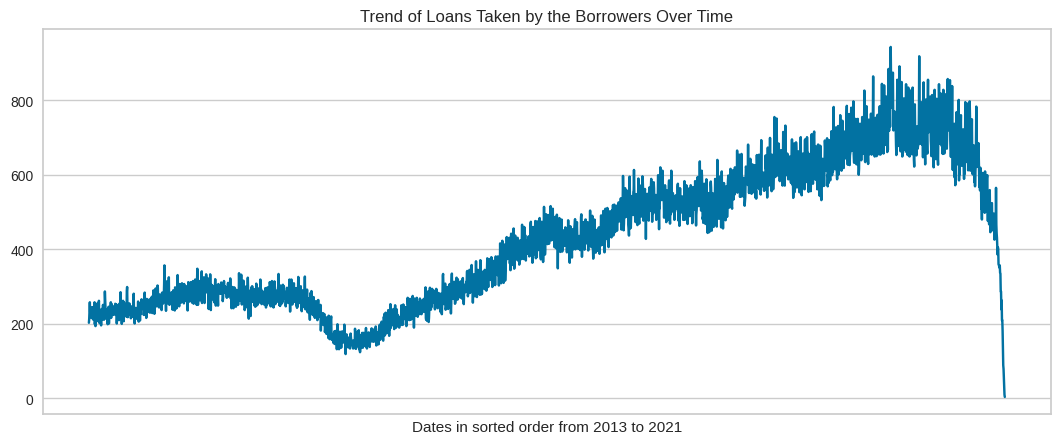

In [ ]:
q = accounts_df['open_date'].value_counts().sort_index()

plt.figure(figsize=(13,5))
plt.plot(range(len(q)), q)
plt.xticks([], [])
plt.title('Trend of Loans Taken by the Borrowers Over Time')
plt.xlabel('Dates in sorted order from 2013 to 2021')
plt.show()

__Findings__
- Number of loans taken by borrowers has increased over time.

# Aggregation of accounts and enquiry data

### Account details

One thing to note is that, there are multiple entries corresponding to the loans taken by the borrowers before they applied for a loan from the  client. For instance, the user with ID **'TNK96292343'** has historical records of 116 loans.

In [ ]:
accounts_df[accounts_df['uid'] == 'TNK96292343']

credit_type  loan_amount  amount_overdue   open_date closed_date  \
931006        Microloan      67500.0             0.0  2020-04-11  2020-04-16   
931007        Microloan      67500.0             0.0  2020-07-07  2020-07-27   
931008        Microloan      36000.0             0.0  2020-09-03  2020-10-17   
931009        Microloan      36000.0             0.0  2020-08-06  2020-10-17   
931010        Microloan      36000.0             0.0  2020-12-10  2020-12-21   
...                 ...          ...             ...         ...         ...   
931117      Credit card     405000.0             0.0  2017-05-04  2020-09-13   
931118  Consumer credit      67500.0             0.0  2016-09-20  2017-09-22   
931119  Consumer credit      39317.4             0.0  2015-03-07  2015-07-08   
931120  Consumer credit      67991.4             0.0  2015-09-19  2016-07-22   
931121  Consumer credit      70870.5             0.0  2013-06-01  2014-04-01   

                                      payment_hist_string          uid  
931006                                                     TNK96292343  
931007                                                     TNK96292343  
931008                                                000  TNK96292343  
931009                                             000000  TNK96292343  
931010                                                     TNK96292343  
...                                                   ...          ...  
931117  0000000000000000000000000000000000000000000000...  TNK96292343  
931118               000000000000000000000000000000000000  TNK96292343  
931119                                       000000000000  TNK96292343  
931120                     000000000000000000000000000000  TNK96292343  
931121                     000000000000000000000000000000  TNK96292343  

[116 rows x 7 columns]

As the task at hand is to predict the loan outcome for the borrower at the time of application, we will first remove these multiple occurences by aggregating the attributes based on the customer ID "uid".

From the given attributes, we can come up with different attributes like:
- number of credit history
- average of number of overdues
- percentage of loans with overdues
- number of open loans
- number of closed loans
- maximum number of defaults for a loan
- average/median of the overdue amount
- average/median of the loan amount taken,
- credit type diversity, etc


**Processing the dataframe to get desired aggregate features:**

In [3]:
def get_overdues_count(string):
    """
    Count the number of overdues for a loan based on payment_hist_string

    Input:
        string: payment history string

    Returns:
        Number of overdues
    """
    if pd.isna(string):
        return 0

    cnt = 0
    for i in range(0, len(string), 3):
        if string[i:i+3] != '000':
            cnt += 1
    return cnt

get_overdues_count('000111000')

1

In [4]:
import scipy.stats as stats
def entropy(series):
    """
    Calculate the entropy of credit types for each borrower.
    """
    p_data = series.value_counts() / len(series)
    return stats.entropy(p_data)

In [5]:
# Define a custom aggregation function
def get_overdue_pct(arr):
    return np.round(len(arr[arr!=0]) / len(arr), 2)

def get_open_loan_count(arr):
    return len(arr[arr.isna()])

def get_closed_loan_count(arr):
    return len(arr[~arr.isna()])

In [ ]:
# number of overdues in a loan
accounts_df['overdue_count'] = accounts_df['payment_hist_string'].apply(get_overdues_count)

agg_accounts_df = accounts_df.groupby('uid').agg(

    # number of credit history
    total_credit_history = ('uid', 'size'),

    # average number of overdues in a loan
    avg_overdue_count    = ('overdue_count', 'mean'),
    # percentage of loans with overdue
    pct_overdue_loans    = ('overdue_count', get_overdue_pct),
    # maximum number of defaults in a loan
    max_overdue_count    = ('overdue_count', 'max'),

    # number of open loans
    cnt_open_loans       = ('closed_date', get_open_loan_count),
    # number of closed loans
    cnt_closed_loans     = ('closed_date', get_closed_loan_count),

    # average/median of the overdue amount
    avg_overdue_amount   = ('amount_overdue', 'mean'),
    med_overdue_amount   = ('amount_overdue', np.median),

    # average/median of the loan amount taken
    avg_loan_amount      = ('loan_amount', 'mean'),
    med_loan_amount      = ('loan_amount', np.median),

    # credit type diversity
    diversity_credit_type = ('credit_type', entropy)

).reset_index()

__SANITY CHECK__

Verifying the number of rows of the final df with the total number of unique borrowers in the given data:

In [ ]:
# checking if the transformation is correct
assert agg_accounts_df.shape[0] == accounts_df.uid.nunique()

In [ ]:
agg_accounts_df.head()

uid  total_credit_history  avg_overdue_count  pct_overdue_loans  \
0  AAA09044550                     2              1.500               1.00   
1  AAA10545297                     1              0.000               0.00   
2  AAA14112888                     1              0.000               0.00   
3  AAA20326915                     8              3.875               0.12   
4  AAA31604840                     5              0.000               0.00   

   max_overdue_count  cnt_open_loans  cnt_closed_loans  avg_overdue_amount  \
0                  2               0                 2                 0.0   
1                  0               1                 0                 0.0   
2                  0               0                 1                 0.0   
3                 31               3                 5                 0.0   
4                  0               3                 2                 0.0   

   med_overdue_amount  avg_loan_amount  med_loan_amount  diversity_credit_type  
0                 0.0       138622.500       138622.500               0.000000  
1                 0.0        80996.445        80996.445               0.000000  
2                 0.0        43771.500        43771.500               0.000000  
3                 0.0        73949.625        46658.250               0.661563  
4                 0.0       318392.100       304965.000               0.500402

In [ ]:
agg_accounts_df[agg_accounts_df['uid'] == 'TNK96292343']

uid  total_credit_history  avg_overdue_count  \
168338  TNK96292343                   116                0.0   

        pct_overdue_loans  max_overdue_count  cnt_open_loans  \
168338                0.0                  0               8   

        cnt_closed_loans  avg_overdue_amount  med_overdue_amount  \
168338               108                 0.0                 0.0   

        avg_loan_amount  med_loan_amount  diversity_credit_type  
168338     79549.672888          45000.0               0.803046

__Observations:__
- As can be seen, the borrowers reports have been aggregated using their ID details.

__The data is ready to be merged with the loan data for further EDA.__

In [ ]:
agg_accounts_df['diversity_credit_type'].describe()

count    223918.000000
mean          0.399124
std           0.328645
min           0.000000
25%           0.000000
50%           0.500402
75%           0.639032
max           1.609438
Name: diversity_credit_type, dtype: float64

In [ ]:
del accounts_df

### Enquiry details

Similar to borrowers historical loan data, there are multiple entries corresponding to the enquiries done by the borrowers for a loan. For instance, the user with ID **'PLY03601601'** has historical records of 69 enquiries.

In [ ]:
enquiry_df[enquiry_df['uid'] == 'PLY03601601']

enquiry_type  enquiry_amt  \
1137999                                    Cash loans       179000   
1138000                                      Mortgage        24000   
1138001                              Interbank credit       147000   
1138002                 Loan for business development        36000   
1138003                     Cash loan (non-earmarked)       141000   
...                                               ...          ...   
1138063  Loan for purchase of shares (margin lending)       143000   
1138064                          Mobile operator loan        36000   
1138065                 Loan for business development         7000   
1138066                          Another type of loan       123000   
1138067                          Mobile operator loan       182000   

        enquiry_date          uid  
1137999   2020-10-25  PLY03601601  
1138000   2019-02-27  PLY03601601  
1138001   2020-02-02  PLY03601601  
1138002   2019-12-20  PLY03601601  
1138003   2018-09-03  PLY03601601  
...              ...          ...  
1138063   2020-08-20  PLY03601601  
1138064   2020-01-01  PLY03601601  
1138065   2020-04-06  PLY03601601  
1138066   2020-05-03  PLY03601601  
1138067   2020-02-07  PLY03601601  

[69 rows x 4 columns]

We will first remove these multiple occurences by aggregating the attributes based on the customer ID "uid".

From the given attributes, we can come up with different attributes like:
- number of enquiries
- average/median of the enquiry amount
- enquiry type diversity, etc


**Processing the dataframe to get desired aggregate features:**

In [ ]:
agg_enquiry_df = enquiry_df.groupby('uid').agg(

    # number of enquiries made
    total_enquiry_count = ('uid', 'size'),

    # average/median of the enquiry amount
    avg_enquiry_amount      = ('enquiry_amt', 'mean'),
    med_enquiry_amount      = ('enquiry_amt', np.median),

    # enquiry type diversity
    diversity_enquiry_type = ('enquiry_type', entropy)

).reset_index()

__SANITY CHECK__

Verifying the number of rows of the final df with the total number of unique borrowers in the given data:

In [ ]:
# checking if the transformation is correct
assert agg_enquiry_df.shape[0] == enquiry_df.uid.nunique()

In [ ]:
agg_enquiry_df.head()

uid  total_enquiry_count  avg_enquiry_amount  med_enquiry_amount  \
0  AAA08065248                   11       187696.181818            169056.0   
1  AAA09044550                   26       102269.230769            106500.0   
2  AAA10545297                   14        94071.428571             94000.0   
3  AAA14112888                   15        97666.666667             95000.0   
4  AAA20326915                    1        66000.000000             66000.0   

   diversity_enquiry_type  
0                1.720193  
1                2.374034  
2                2.143952  
3                2.245952  
4                0.000000

In [ ]:
agg_enquiry_df[agg_enquiry_df['uid'] == 'PLY03601601']

uid  total_enquiry_count  avg_enquiry_amount  \
155554  PLY03601601                   69        95434.782609   

        med_enquiry_amount  diversity_enquiry_type  
155554             88000.0                2.753382

__Observations:__
- As can be seen, the borrowers reports have been aggregated using their ID details.

__The data is ready to be merged with the loan data for further EDA.__

In [ ]:
del enquiry_df

# Merging Loan, Accounts, and Enquiry data

In [ ]:
loan_df.head(2)

uid NAME_CONTRACT_TYPE  TARGET
0  XDA69787158         Cash loans       0
1  BSE47789733         Cash loans       0

In [ ]:
agg_accounts_df.head(2)

uid  total_credit_history  avg_overdue_count  pct_overdue_loans  \
0  AAA09044550                     2                1.5                1.0   
1  AAA10545297                     1                0.0                0.0   

   max_overdue_count  cnt_open_loans  cnt_closed_loans  avg_overdue_amount  \
0                  2               0                 2                 0.0   
1                  0               1                 0                 0.0   

   med_overdue_amount  avg_loan_amount  med_loan_amount  diversity_credit_type  
0                 0.0       138622.500       138622.500                    0.0  
1                 0.0        80996.445        80996.445                    0.0

In [ ]:
agg_enquiry_df.head(2)

uid  total_enquiry_count  avg_enquiry_amount  med_enquiry_amount  \
0  AAA08065248                   11       187696.181818            169056.0   
1  AAA09044550                   26       102269.230769            106500.0   

   diversity_enquiry_type  
0                1.720193  
1                2.374034

In [ ]:
final_df = loan_df.merge(agg_accounts_df, on='uid', how='left')\
                  .merge(agg_enquiry_df,  on='uid', how='left')

final_df.head()

uid NAME_CONTRACT_TYPE  TARGET  total_credit_history  \
0  XDA69787158         Cash loans       0                   1.0   
1  BSE47789733         Cash loans       0                   1.0   
2  NTJ92213825         Cash loans       0                   1.0   
3  TCQ47571695         Cash loans       0                   3.0   
4  WJZ68772744         Cash loans       0                   NaN   

   avg_overdue_count  pct_overdue_loans  max_overdue_count  cnt_open_loans  \
0                0.0                0.0                0.0             1.0   
1                0.0                0.0                0.0             0.0   
2                0.0                0.0                0.0             0.0   
3                0.0                0.0                0.0             1.0   
4                NaN                NaN                NaN             NaN   

   cnt_closed_loans  avg_overdue_amount  med_overdue_amount  avg_loan_amount  \
0               0.0                 0.0                 0.0         450000.0   
1               1.0                 0.0                 0.0         110155.5   
2               1.0                 0.0                 0.0         103783.5   
3               2.0                 0.0                 0.0         224292.0   
4               NaN                 NaN                 NaN              NaN   

   med_loan_amount  diversity_credit_type  total_enquiry_count  \
0         450000.0               0.000000                    2   
1         110155.5               0.000000                    3   
2         103783.5               0.000000                    4   
3         159525.0               0.636514                    1   
4              NaN                    NaN                   22   

   avg_enquiry_amount  med_enquiry_amount  diversity_enquiry_type  
0       135500.000000            135500.0                0.693147  
1       144333.333333            150000.0                1.098612  
2       120500.000000            153500.0                1.039721  
3       148000.000000            148000.0                0.000000  
4       110318.181818            109000.0                2.476354

In [ ]:
del loan_df, agg_accounts_df, agg_enquiry_df

# EDA

We did some surface scratching and found some basic details of the individual datasets. These information gave us an insight about how to combine them into a single data frame.

Now we will do in depth exploration of the dataset and try to come up with some possible actionable insights.

**Quick look at the TARGET distribution**

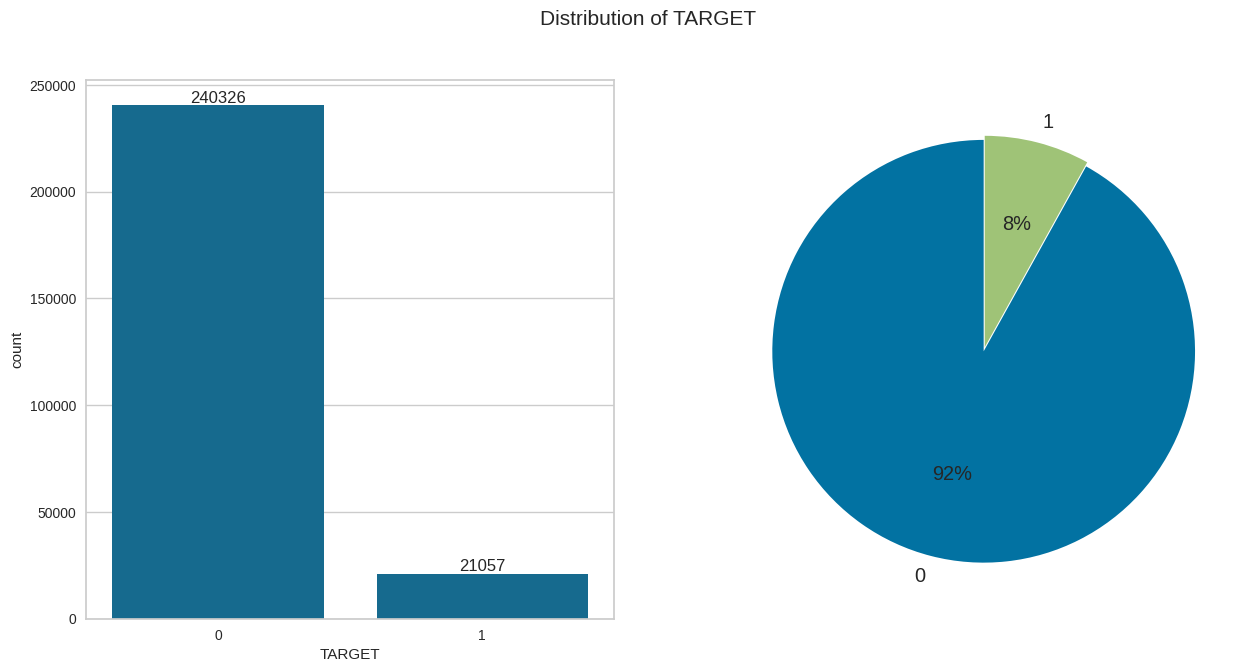

In [ ]:
make_categorical_plots(final_df, 'TARGET')

**Findings**
- We are dealing with an imbalanced data
- We need to keep intact the distribution of default loan cases and the loan that were paid on time. Hence, we will do **stratified sampling**.

In [ ]:
Y = final_df['TARGET']
X = final_df.drop(columns=['TARGET', 'uid'])

In [ ]:
X.head(2)

NAME_CONTRACT_TYPE  total_credit_history  avg_overdue_count  \
0         Cash loans                   1.0                0.0   
1         Cash loans                   1.0                0.0   

   pct_overdue_loans  max_overdue_count  cnt_open_loans  cnt_closed_loans  \
0                0.0                0.0             1.0               0.0   
1                0.0                0.0             0.0               1.0   

   avg_overdue_amount  med_overdue_amount  avg_loan_amount  med_loan_amount  \
0                 0.0                 0.0         450000.0         450000.0   
1                 0.0                 0.0         110155.5         110155.5   

   diversity_credit_type  total_enquiry_count  avg_enquiry_amount  \
0                    0.0                    2       135500.000000   
1                    0.0                    3       144333.333333   

   med_enquiry_amount  diversity_enquiry_type  
0            135500.0                0.693147  
1            150000.0                1.098612

In [ ]:
del final_df

## Checking Missing Values and Outliers

In [ ]:
stats_summary(X, 'numeric')

count           mean            std     min  \
total_credit_history    223918.0       5.532825       4.357459     1.0   
avg_overdue_count       223918.0       0.284619       0.948953     0.0   
pct_overdue_loans       223918.0       0.085437       0.162214     0.0   
max_overdue_count       223918.0       1.346560       3.473042     0.0   
cnt_open_loans          223918.0       2.050286       1.771395     0.0   
cnt_closed_loans        223918.0       3.482538       3.381930     0.0   
avg_overdue_amount      223918.0      55.048313    5729.277722     0.0   
med_overdue_amount      223918.0      24.849239    4760.988610     0.0   
avg_loan_amount         223917.0  378846.704825  915309.922588     0.0   
med_loan_amount         223917.0  273770.152480  850850.345997     0.0   
diversity_credit_type   223918.0       0.399124       0.328645     0.0   
total_enquiry_count     261383.0       7.306967       6.996937     1.0   
avg_enquiry_amount      261383.0  116058.619950   60605.819470  1057.0   
med_enquiry_amount      261383.0  116089.412167   64846.114297  1057.0   
diversity_enquiry_type  261383.0       1.256884       0.825607     0.0   

                                  25%            50%            75%  \
total_credit_history         2.000000       4.000000       8.000000   
avg_overdue_count            0.000000       0.000000       0.222222   
pct_overdue_loans            0.000000       0.000000       0.130000   
max_overdue_count            0.000000       0.000000       1.000000   
cnt_open_loans               1.000000       2.000000       3.000000   
cnt_closed_loans             1.000000       3.000000       5.000000   
avg_overdue_amount           0.000000       0.000000       0.000000   
med_overdue_amount           0.000000       0.000000       0.000000   
avg_loan_amount         103500.000000  195405.940000  394457.565000   
med_loan_amount          73705.500000  133580.160000  247500.000000   
diversity_credit_type        0.000000       0.500402       0.639032   
total_enquiry_count          2.000000       5.000000      10.000000   
avg_enquiry_amount       86285.714286  104714.285714  127389.277389   
med_enquiry_amount       79500.000000  106000.000000  136000.000000   
diversity_enquiry_type       0.693147       1.386294       1.945910   

                                 max  Count of Outliers  
total_credit_history    1.160000e+02               4525  
avg_overdue_count       3.900000e+01              29511  
pct_overdue_loans       1.000000e+00              19422  
max_overdue_count       8.100000e+01              34231  
cnt_open_loans          3.200000e+01               5279  
cnt_closed_loans        1.080000e+02               7051  
avg_overdue_amount      1.617404e+06               2829  
med_overdue_amount      1.617404e+06                374  
avg_loan_amount         1.980723e+08              20453  
med_loan_amount         1.980723e+08              22988  
diversity_credit_type   1.609438e+00                  1  
total_enquiry_count     6.900000e+01              11373  
avg_enquiry_amount      4.999600e+05              28831  
med_enquiry_amount      4.999600e+05              15626  
diversity_enquiry_type  2.787589e+00                  0

In [ ]:
X.describe(include='object')

NAME_CONTRACT_TYPE
count              261383
unique                  2
top            Cash loans
freq               236524

In [ ]:
missing_val_overview(X)

Value
No. of Rows with missing values                 37466
No. of columns with zero missing cases              5
No. of columns with >0 and <=50% missing cases     11
No. of columns with >50% missing cases              0
No. of columns with >90% missing cases              0

In [ ]:
X.isna().sum()

NAME_CONTRACT_TYPE            0
total_credit_history      37465
avg_overdue_count         37465
pct_overdue_loans         37465
max_overdue_count         37465
cnt_open_loans            37465
cnt_closed_loans          37465
avg_overdue_amount        37465
med_overdue_amount        37465
avg_loan_amount           37466
med_loan_amount           37466
diversity_credit_type     37465
total_enquiry_count           0
avg_enquiry_amount            0
med_enquiry_amount            0
diversity_enquiry_type        0
dtype: int64

__Findings__
- There are many rows with missing values
- The distributions are also skewed, and has outliers
- The missing values are due to the absence of historical credit records

**Note:** The outliers are the data points lying outside the range `[25th %tile - 1.5IQR, 75th %tile + 1.5IQR]`

The fence values are computed as illustrated in the image below:

![](http://www.nathalievialaneix.eu/teaching/biostat1/img/boxplot_explanation.png)

## Univariate Analysis

In this section, we will explore the individual features in more details.

### Categorical Attributes

#### NAME_CONTRACT_TYPE

In [ ]:
X['NAME_CONTRACT_TYPE'].value_counts(normalize=True)*100

Cash loans         90.489435
Revolving loans     9.510565
Name: NAME_CONTRACT_TYPE, dtype: float64

In [ ]:
X['NAME_CONTRACT_TYPE'].nunique()

2

__Findings:__
- Types of Lendings by the client are of 2 types : Cash Loans, and Revolving Loans

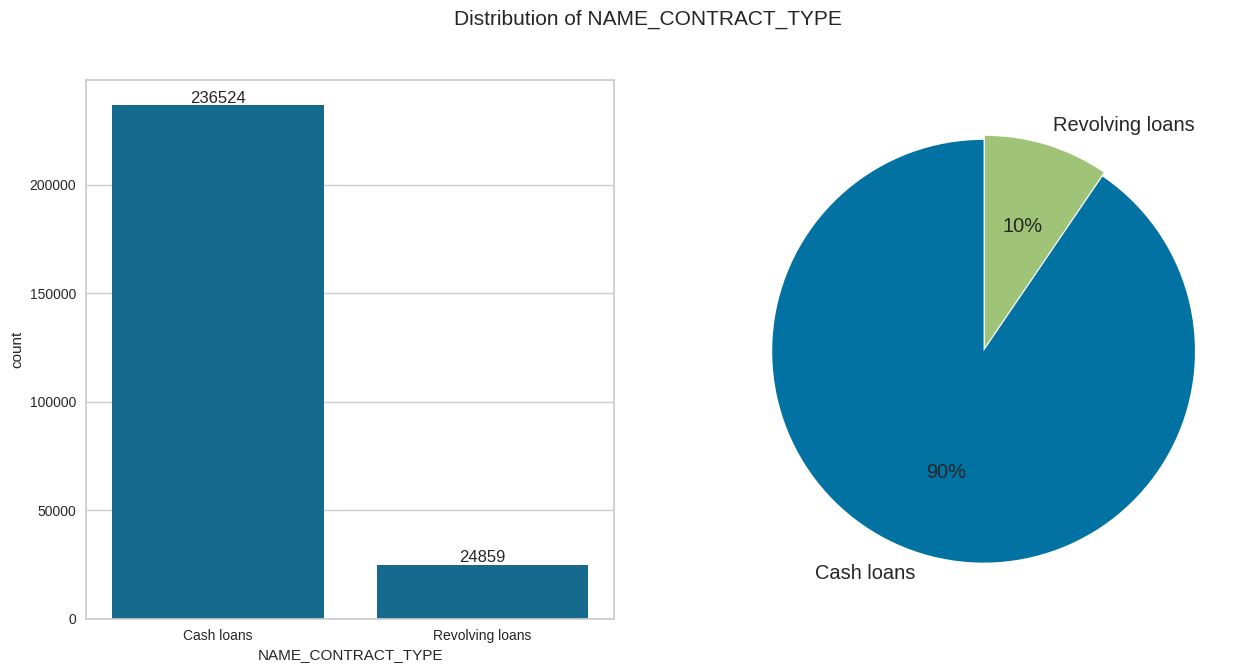

In [ ]:
make_categorical_plots(X, 'NAME_CONTRACT_TYPE')

__Findings:__
- 90% is cash loan
- 10% is revolving loan

### Numerical Attributes

In [ ]:
def make_numerical_plots(df, feature, bins='auto'):
    """
    Method to make univariate numerical plot

    Params:
        df: pandas dataframe
        feature: attribute name
        bins: number of bins

    Returns:
        None
    """
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(13,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    sns.boxplot(df[feature], ax=ax_box)
    sns.histplot(data=df, x=feature, ax=ax_hist, kde=True, bins=bins)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()

def plot_percentiles(data, percentiles):
    """
    Plot percentile values of a distribution.

    Parameters:
    - data: 1D array or list
        The data array for which percentiles are calculated.
    - percentiles: list of floats
        List of percentiles to be plotted (e.g., [25, 50, 75]).

    Returns:
    - None
    """
    # Calculate percentiles
    percentiles_values = np.percentile(data, percentiles)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(percentiles, percentiles_values, marker='o', linestyle='-', color='b')
    plt.title('Percentile Values of the Distribution')
    plt.xlabel('Percentiles')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

#### Credit History

In [ ]:
print(f'Number of missing values: {X["total_credit_history"].isna().sum()}')

Number of missing values: 37465


In [ ]:
X['total_credit_history'].describe()

count    223918.000000
mean          5.532825
std           4.357459
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         116.000000
Name: total_credit_history, dtype: float64

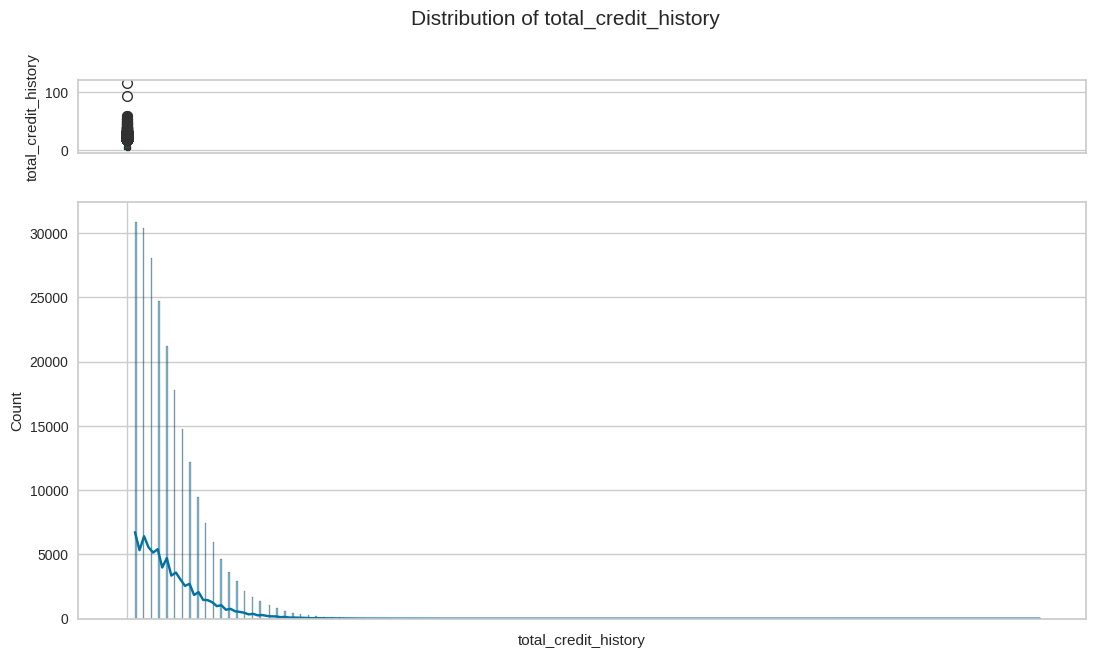

In [ ]:
make_numerical_plots(X, 'total_credit_history')

__Findings:__
- Missing values are present due to the absence of credit history. We can impute them with zeroes.
- The credit history range from 1 to 116
- The average credit history of a borrower is 5
- The distribution is highly skewed indicating presence of outliers

In [ ]:
X["total_credit_history"] = X["total_credit_history"].fillna(0)

__Understanding of Outliers:__


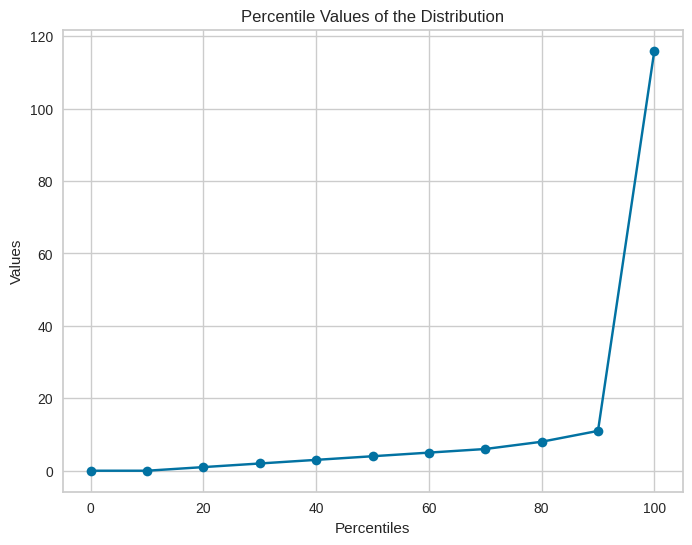

In [ ]:
plot_percentiles(X["total_credit_history"], list(np.arange(0, 101, 10)))

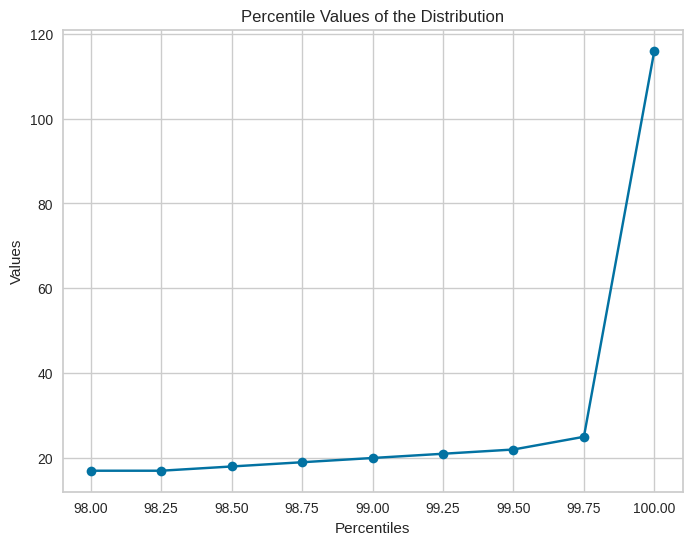

In [ ]:
plot_percentiles(X["total_credit_history"], list(np.arange(98, 100.1, 0.25)))

In [ ]:
X[X["total_credit_history"] > np.percentile(X["total_credit_history"], 99.75)].shape[0]

613

__Findings__
- The distribution is skewed due to the presence of outliers.
- Data suggests the values beyond 99.75 goes up drastically. As there are only ~600+ entries beyond this percentile, we can safely drop these entries. However, we will explore further if larger values has any impact on the loan outcome.

#### Open & Closed Loans

In [ ]:
print(f'Number of missing values in cnt_open_loans: {X["cnt_open_loans"].isna().sum()}')
print(f'Number of missing values in cnt_closed_loans: {X["cnt_closed_loans"].isna().sum()}')

Number of missing values in cnt_open_loans: 37465
Number of missing values in cnt_closed_loans: 37465


__Findings:__
- Missing values are present due to the absence of credit history. We can impute them with 0.

In [ ]:
X['cnt_open_loans'] = X['cnt_open_loans'].fillna(0)
X['cnt_closed_loans'] = X['cnt_closed_loans'].fillna(0)

In [ ]:
X['cnt_open_loans'].describe()

count    261383.000000
mean          1.756411
std           1.790041
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          32.000000
Name: cnt_open_loans, dtype: float64

In [ ]:
X['cnt_closed_loans'].describe()

count    261383.000000
mean          2.983373
std           3.359654
min           0.000000
25%           0.000000
50%           2.000000
75%           4.000000
max         108.000000
Name: cnt_closed_loans, dtype: float64

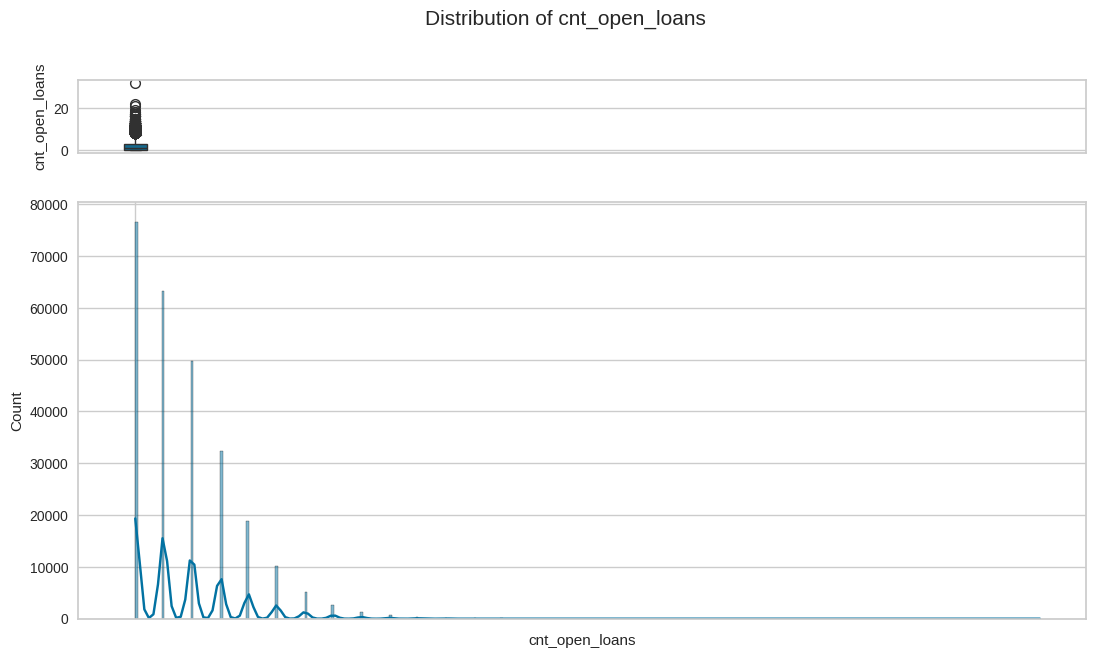

In [ ]:
make_numerical_plots(X, 'cnt_open_loans')

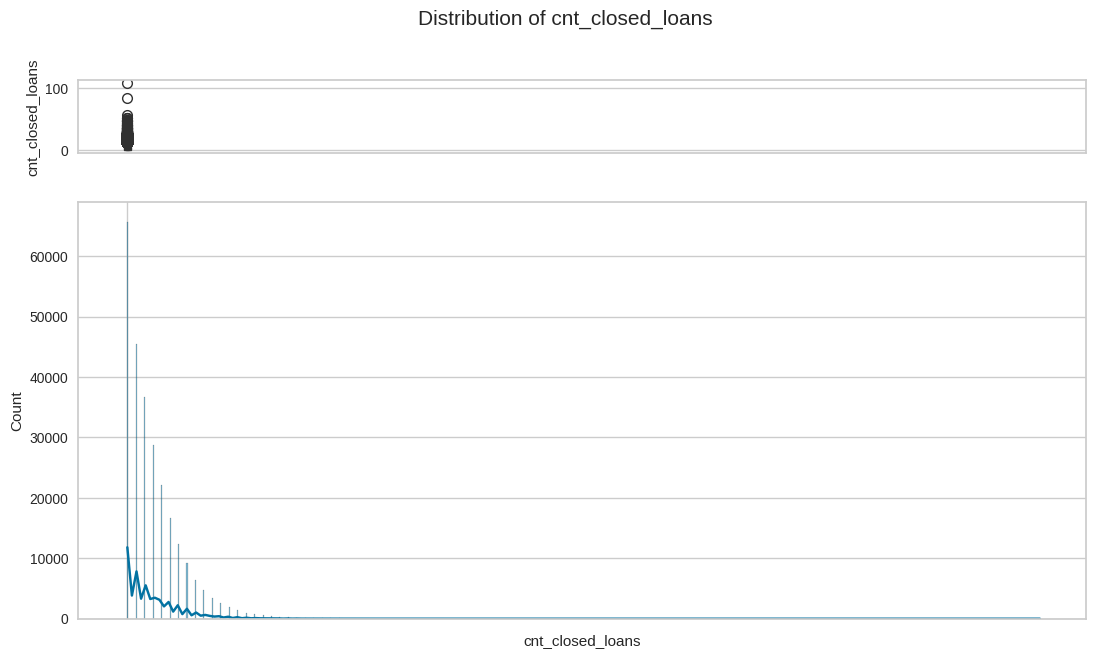

In [ ]:
make_numerical_plots(X, 'cnt_closed_loans')

__Findings:__
- The distributions are skewed indicating presence of outliers

__Understanding of Outliers:__


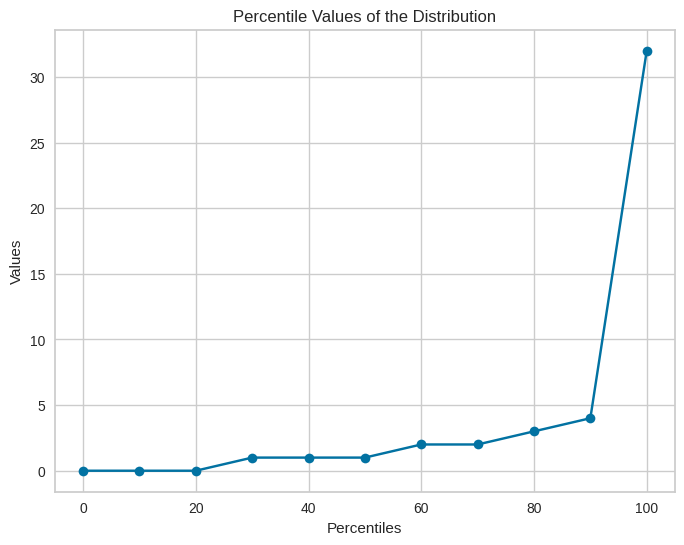

In [ ]:
plot_percentiles(X["cnt_open_loans"], list(np.arange(0, 101, 10)))

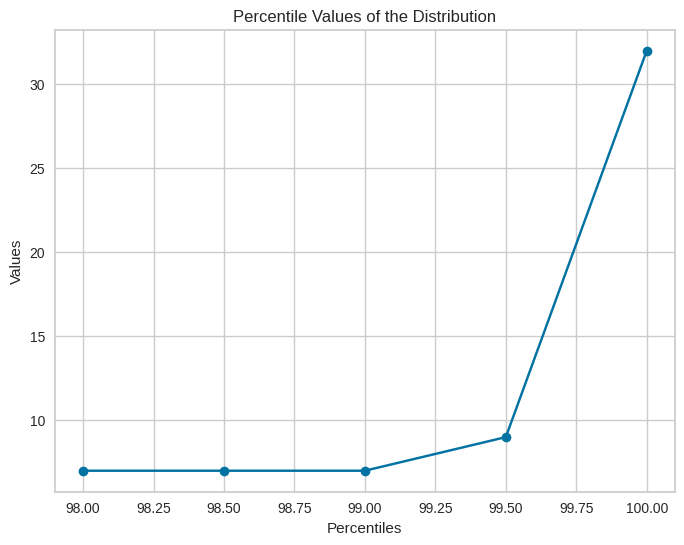

In [ ]:
plot_percentiles(X["cnt_open_loans"], list(np.arange(98, 100.1, 0.5)))

In [ ]:
X[X["cnt_open_loans"] > np.percentile(X["cnt_open_loans"].dropna(), 99.50)].shape[0]

668

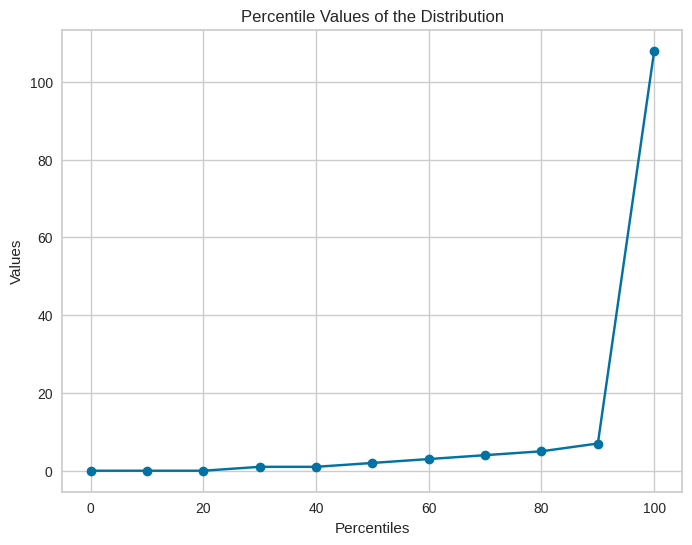

In [ ]:
plot_percentiles(X["cnt_closed_loans"], list(np.arange(0, 101, 10)))

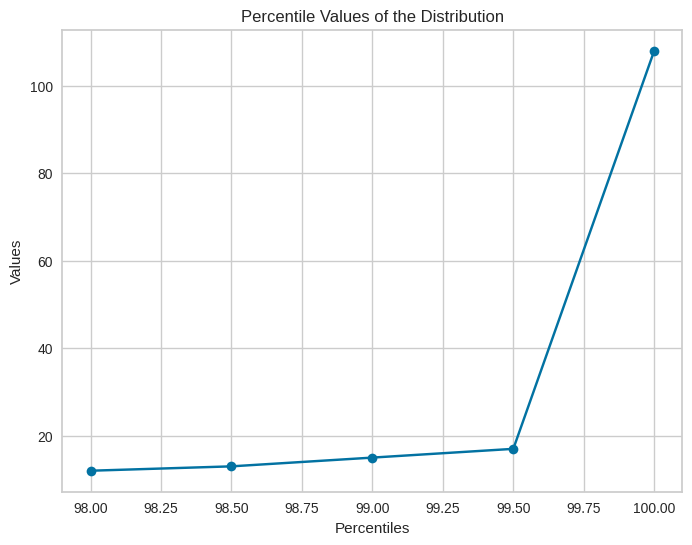

In [ ]:
plot_percentiles(X["cnt_closed_loans"], list(np.arange(98, 100.1, 0.5)))

In [ ]:
X[X["cnt_closed_loans"] > np.percentile(X["cnt_closed_loans"].dropna(), 99.50)].shape[0]

1107

__Findings__
- The distribution is skewed due to the presence of outliers.
- There are around 700-1000 entries beyond 99.5 percentile for both the distribution, we can safely drop these entries. However, we will explore further if larger values has any impact on the loan outcome.

#### Loan Amount

In [ ]:
print(f'Number of missing values in avg_loan_amount: {X["avg_loan_amount"].isna().sum()}')
print(f'Number of missing values in med_loan_amount: {X["med_loan_amount"].isna().sum()}')

Number of missing values in avg_loan_amount: 37466
Number of missing values in med_loan_amount: 37466


__Findings:__
- Missing values are present due to the absence of credit history. We can impute them with a zeroes.

In [ ]:
X['avg_loan_amount'] = X['avg_loan_amount'].fillna(0)
X['med_loan_amount'] = X['med_loan_amount'].fillna(0)

##### avg_loan_amount

In [ ]:
X['avg_loan_amount'].describe()

count    2.613830e+05
mean     3.245437e+05
std      8.575129e+05
min      0.000000e+00
25%      6.707653e+04
50%      1.586033e+05
75%      3.445059e+05
max      1.980723e+08
Name: avg_loan_amount, dtype: float64

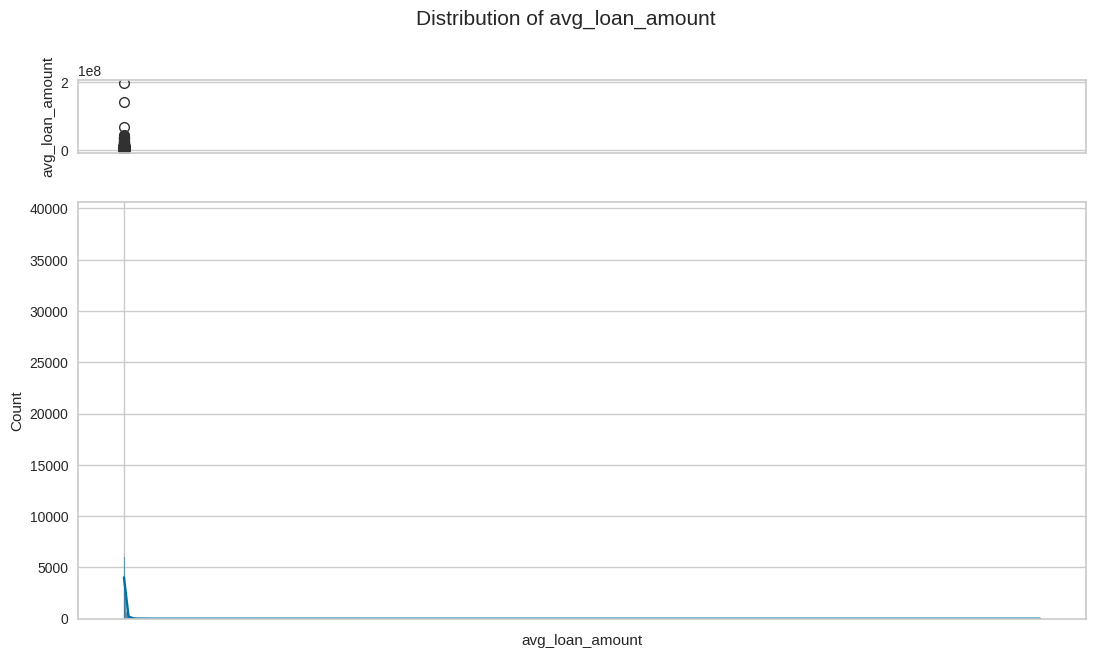

In [ ]:
make_numerical_plots(X, 'avg_loan_amount')

In [ ]:
X['avg_loan_amount'].max()

198072344.25

__Findings:__
- Some borrowers take loan of upto 19Cr on average.
- The distribution is highly skewed indicating presence of outliers

__Understanding of Outliers:__


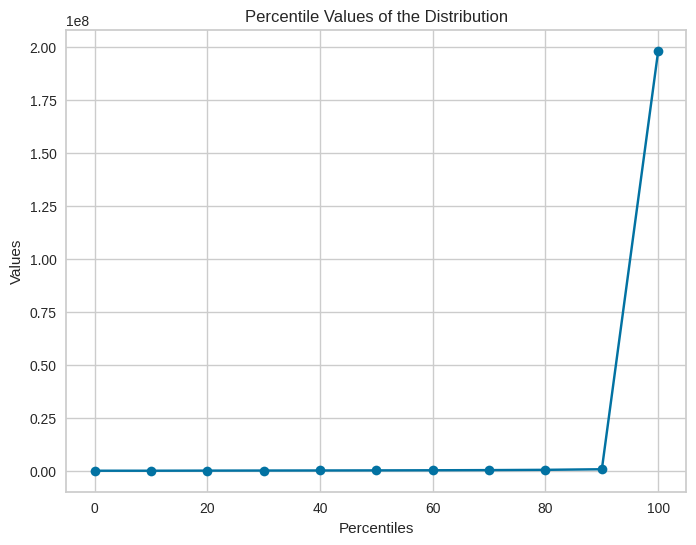

In [ ]:
plot_percentiles(X["avg_loan_amount"].dropna(), list(np.arange(0, 101, 10)))

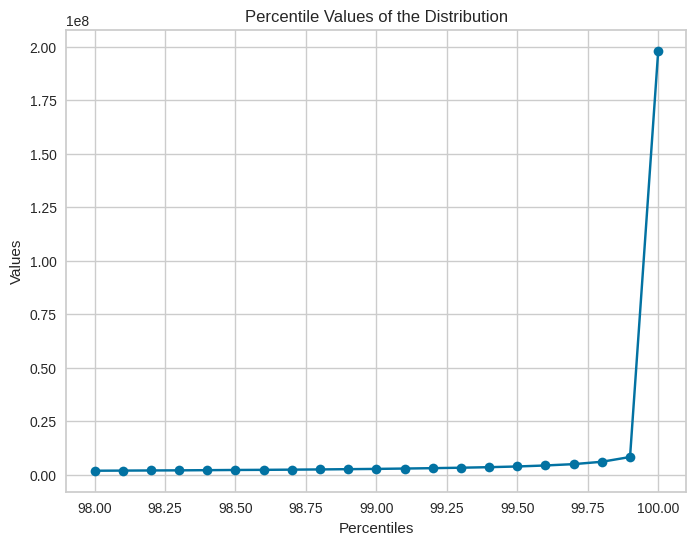

In [ ]:
plot_percentiles(X["avg_loan_amount"].dropna(), list(np.arange(98, 100.05, 0.1)))

In [ ]:
X[X["avg_loan_amount"] > np.percentile(X['avg_loan_amount'].dropna(), 99.75)].shape[0]

654

__Findings__
- The distribution is skewed due to the presence of outliers.
- Data suggests the values beyond 99.7 goes up drastically. As there are only 500+ entries beyond this percentile, we can safely drop these entries. However, we will explore further if larger values has any impact on the loan outcome.

##### med_loan_amount

In [ ]:
X['med_loan_amount'].describe()

count    2.613830e+05
mean     2.345286e+05
std      7.933351e+05
min      0.000000e+00
25%      4.848300e+04
50%      1.100250e+05
75%      2.250000e+05
max      1.980723e+08
Name: med_loan_amount, dtype: float64

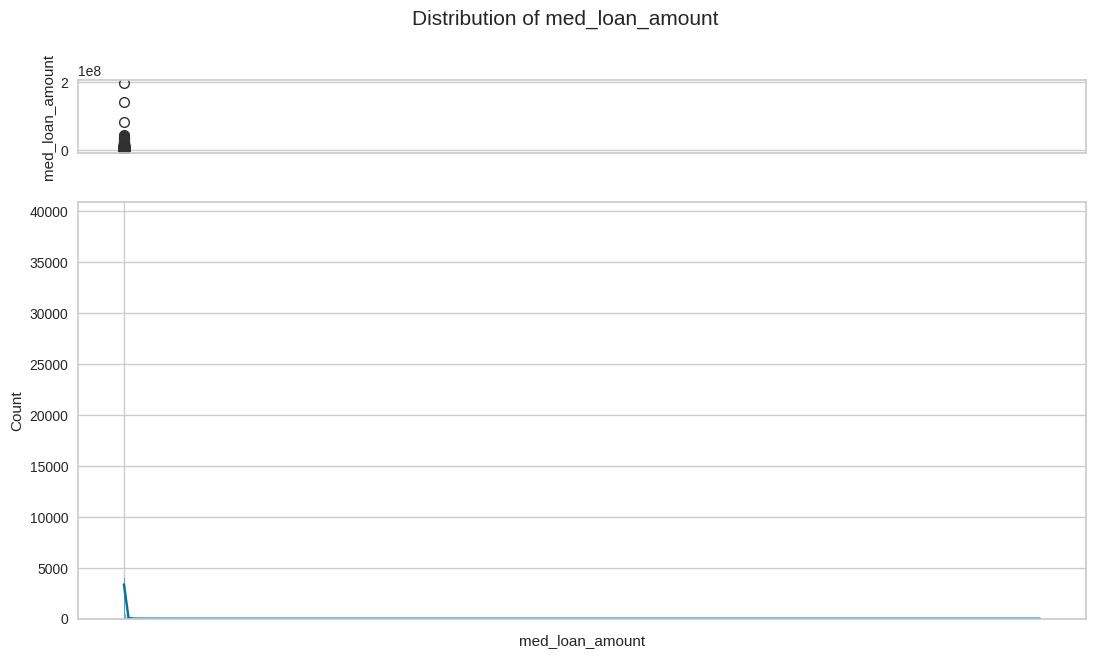

In [ ]:
make_numerical_plots(X, 'med_loan_amount')

__Understanding of Outliers:__


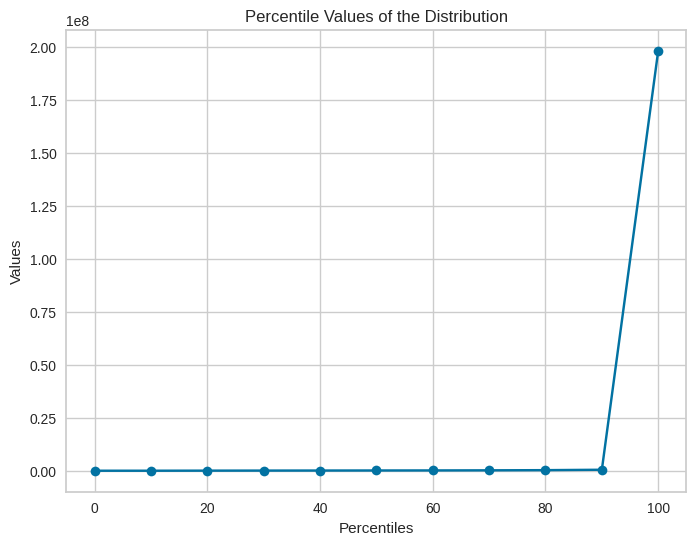

In [ ]:
plot_percentiles(X["med_loan_amount"].dropna(), list(np.arange(0, 101, 10)))

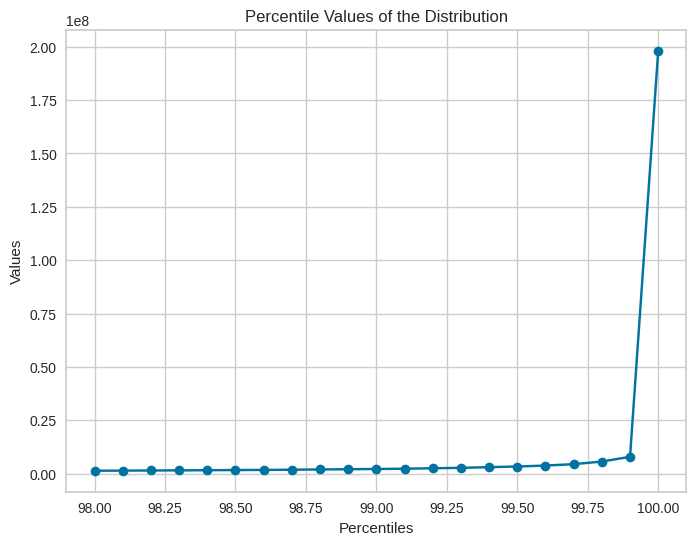

In [ ]:
plot_percentiles(X["med_loan_amount"].dropna(), list(np.arange(98, 100.05, 0.1)))

In [ ]:
X[X["med_loan_amount"] > np.percentile(X['med_loan_amount'].dropna(), 99.75)].shape[0]

654

__Findings__
- The distribution is skewed due to the presence of outliers.
- Data suggests the values beyond 99.7 goes up drastically. As there are only 500+ entries beyond this percentile, we can safely drop these entries. However, we will explore further if larger values has any impact on the loan outcome.

#### Diversity of Credit and Enquiry Type

In [ ]:
print(f'Number of missing values diversity_credit_type: {X["diversity_credit_type"].isna().sum()}')
print(f'Number of missing values diversity_enquiry_type: {X["diversity_enquiry_type"].isna().sum()}')

Number of missing values diversity_credit_type: 37465
Number of missing values diversity_enquiry_type: 0


__Findings:__
- Missing values are present due to the absence of credit history. We can impute them with a zeroes.

In [ ]:
X['diversity_credit_type'] = X['diversity_credit_type'].fillna(0)

In [ ]:
X['diversity_credit_type'].describe()

count    261383.000000
mean          0.341916
std           0.334794
min           0.000000
25%           0.000000
50%           0.410116
75%           0.636514
max           1.609438
Name: diversity_credit_type, dtype: float64

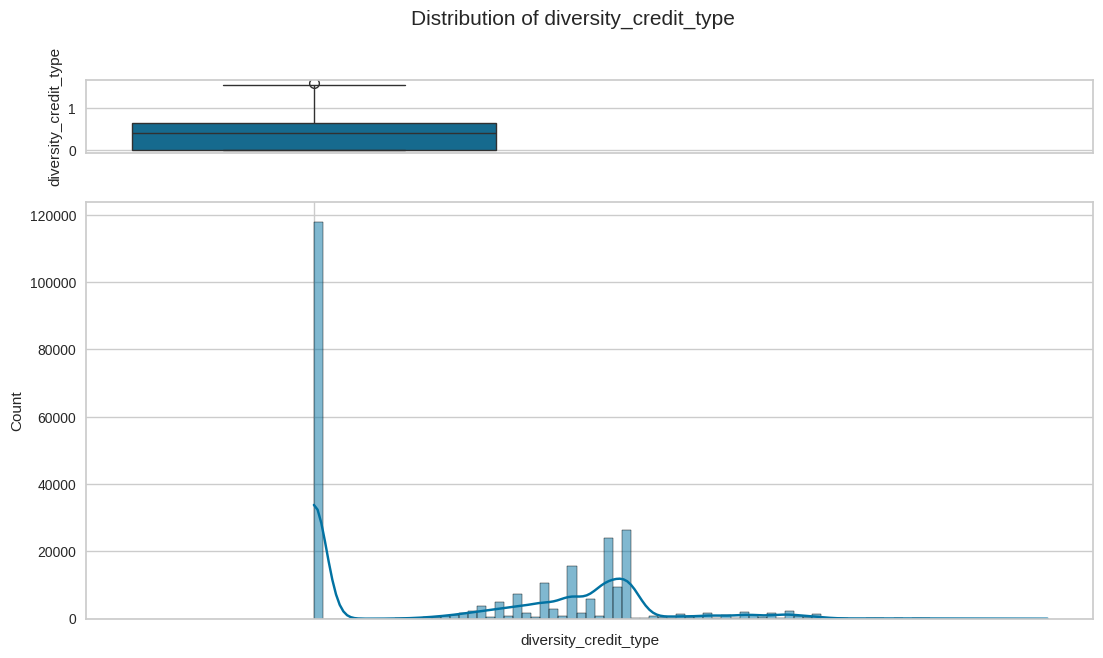

In [ ]:
make_numerical_plots(X, 'diversity_credit_type')

__Findings:__
- There is a peak at 0 because we filled many values with 0

In [ ]:
X['diversity_enquiry_type'].describe()

count    261383.000000
mean          1.256884
std           0.825607
min           0.000000
25%           0.693147
50%           1.386294
75%           1.945910
max           2.787589
Name: diversity_enquiry_type, dtype: float64

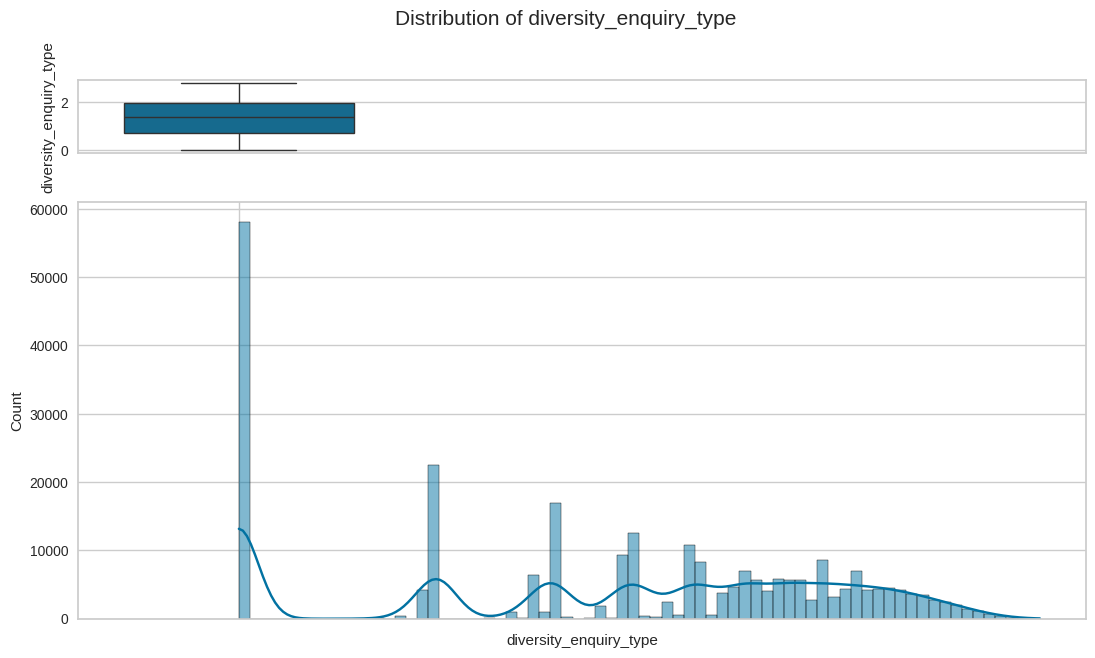

In [ ]:
make_numerical_plots(X, 'diversity_enquiry_type')

__Findings:__
- People displays a large range of in requirements. There are people who enquire about only one type of loan (entries with diversity close to 0), and also there are people who enquire about different types of loans over time (entries with diversity with a value large than 0).

#### Overdues

In [ ]:
print(f'Number of missing values in avg_overdue_count: {X["avg_overdue_count"].isna().sum()}')
print(f'Number of missing values in pct_overdue_loans: {X["pct_overdue_loans"].isna().sum()}')
print(f'Number of missing values in max_overdue_count: {X["max_overdue_count"].isna().sum()}')
print(f'Number of missing values in avg_overdue_amount: {X["avg_overdue_amount"].isna().sum()}')
print(f'Number of missing values in med_overdue_amount: {X["med_overdue_amount"].isna().sum()}')

Number of missing values in avg_overdue_count: 37465
Number of missing values in pct_overdue_loans: 37465
Number of missing values in max_overdue_count: 37465
Number of missing values in avg_overdue_amount: 37465
Number of missing values in med_overdue_amount: 37465


__Findings:__
- Missing values are present due to the absence of credit history. We can impute them with a 0

In [ ]:
X["avg_overdue_count"] = X["avg_overdue_count"].fillna(0)
X["pct_overdue_loans"] = X["pct_overdue_loans"].fillna(0)
X["max_overdue_count"] = X["max_overdue_count"].fillna(0)

X["avg_overdue_amount"] = X["avg_overdue_amount"].fillna(0)
X["med_overdue_amount"] = X["med_overdue_amount"].fillna(0)

##### avg_overdue_count

In [ ]:
X['avg_overdue_count'].describe()

count    261383.000000
mean          0.243823
std           0.883960
min           0.000000
25%           0.000000
50%           0.000000
75%           0.153846
max          39.000000
Name: avg_overdue_count, dtype: float64

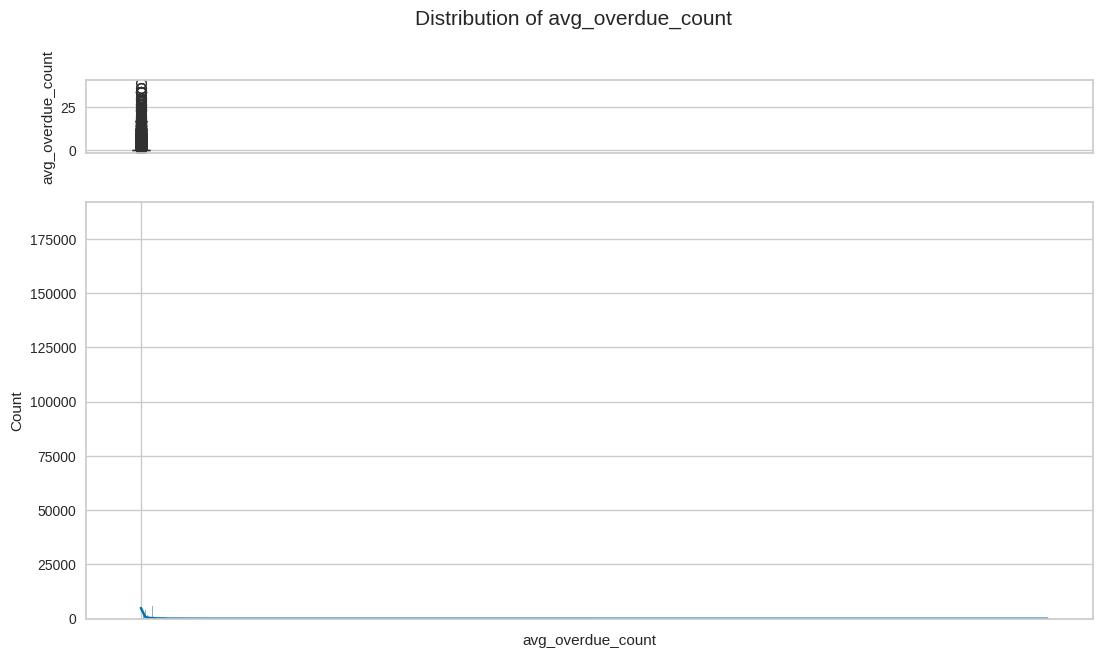

In [ ]:
make_numerical_plots(X, 'avg_overdue_count')

__Findings:__
- The overdue count range from 0 to 39
- The distribution is highly skewed indicating presence of outliers

__Understanding of Outliers:__


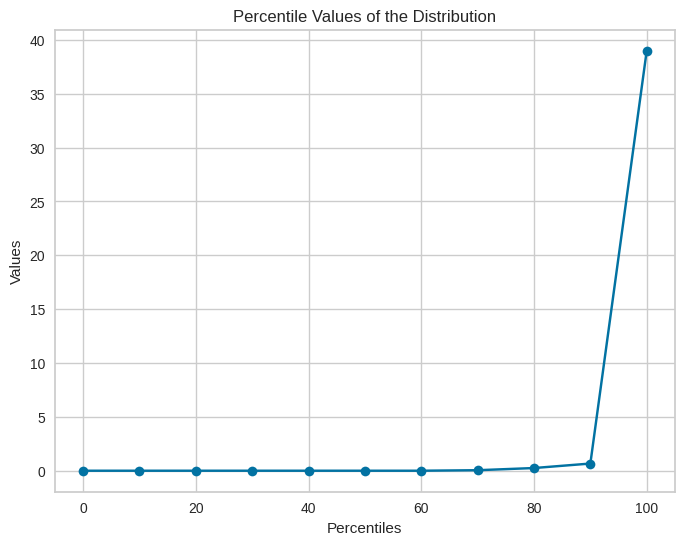

In [ ]:
plot_percentiles(X["avg_overdue_count"].dropna(), list(np.arange(0, 101, 10)))

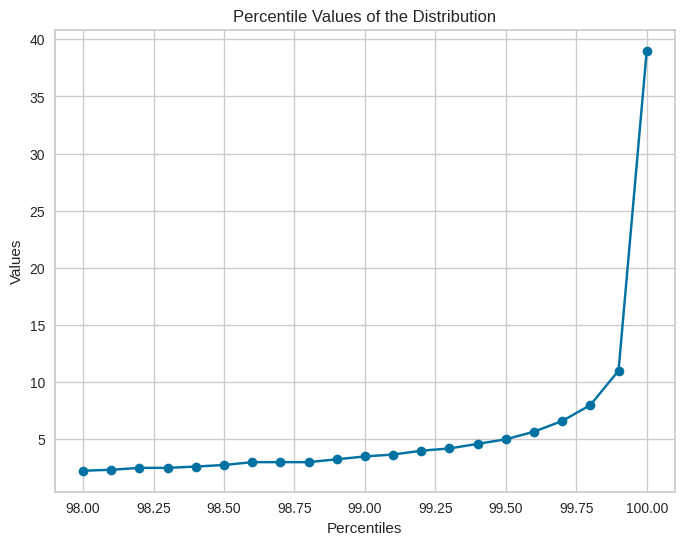

In [ ]:
plot_percentiles(X["avg_overdue_count"].dropna(), list(np.arange(98, 100.05, 0.1)))

In [ ]:
X[X["avg_overdue_count"] > 13].shape[0]

165

__Findings__
- The distribution is skewed due to the presence of outliers.
- Data suggests the values beyond 99.9 goes up drastically. As there are only 100+ entries beyond this percentile, we can safely drop these entries. However, we will explore further if larger values has any impact on the loan outcome.

##### pct_overdue_loans

In [ ]:
X['pct_overdue_loans'].describe()

count    261383.000000
mean          0.073191
std           0.153095
min           0.000000
25%           0.000000
50%           0.000000
75%           0.110000
max           1.000000
Name: pct_overdue_loans, dtype: float64

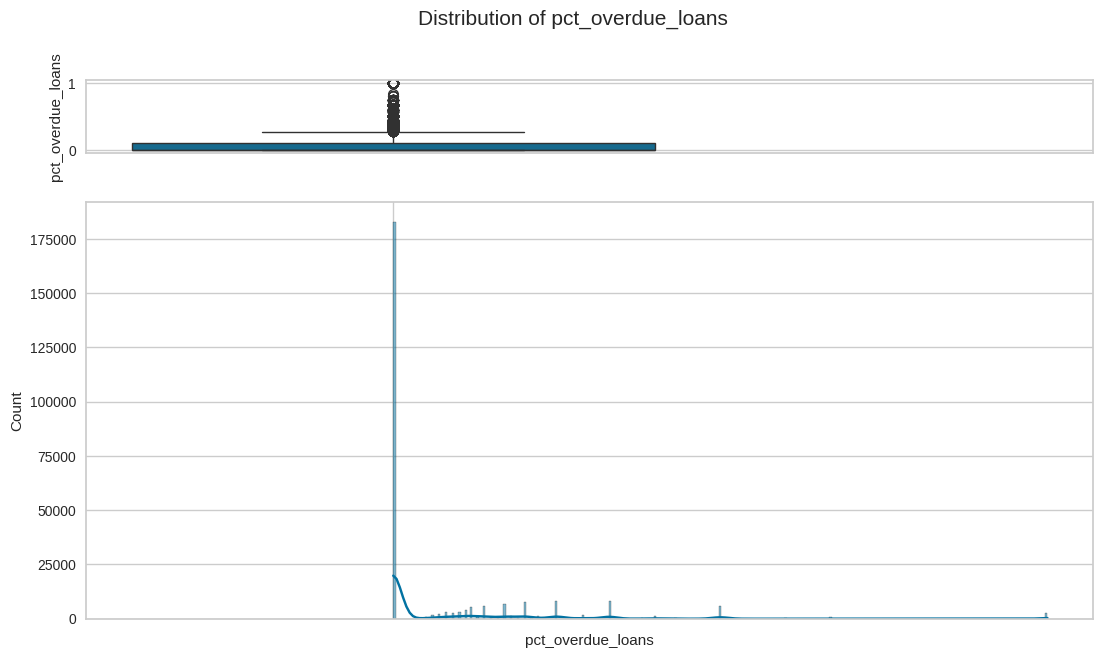

In [ ]:
make_numerical_plots(X, 'pct_overdue_loans')

__Findings:__
- The percentage of loans where there borrowers has overdues is very less. It is only about 7%

##### max_overdue_count

In [ ]:
X['max_overdue_count'].describe()

count    261383.000000
mean          1.153552
std           3.248964
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          81.000000
Name: max_overdue_count, dtype: float64

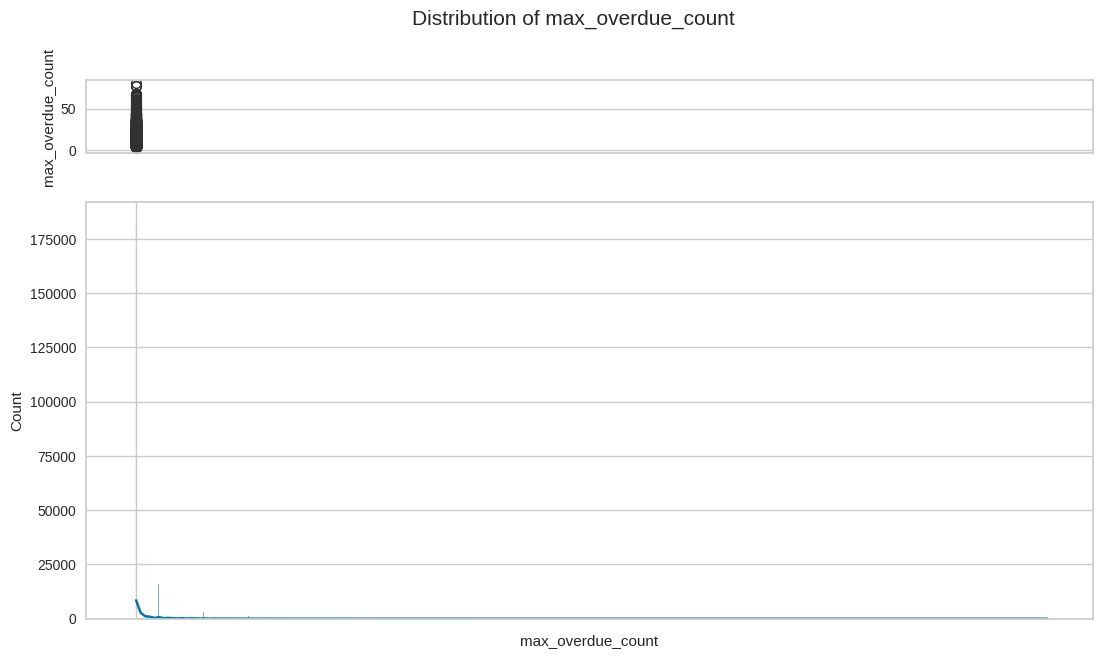

In [ ]:
make_numerical_plots(X, 'max_overdue_count')

__Findings:__
- 81 is the highest count of overdues in a loan by a borrower

__Understanding of Outliers:__


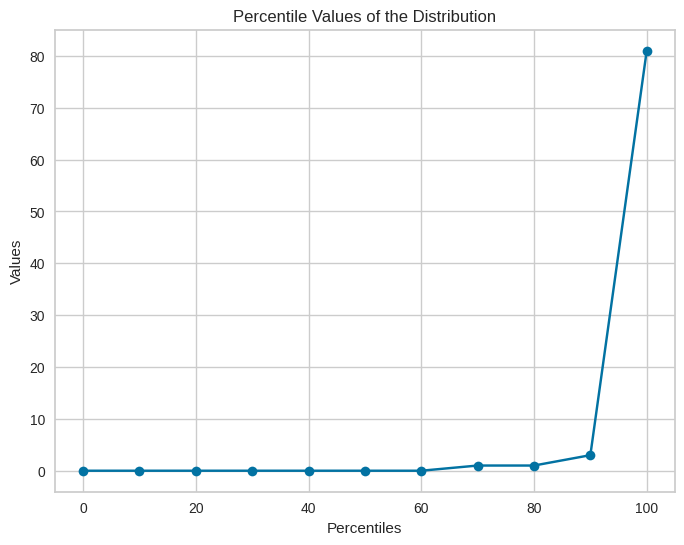

In [ ]:
plot_percentiles(X["max_overdue_count"].dropna(), list(np.arange(0, 101, 10)))

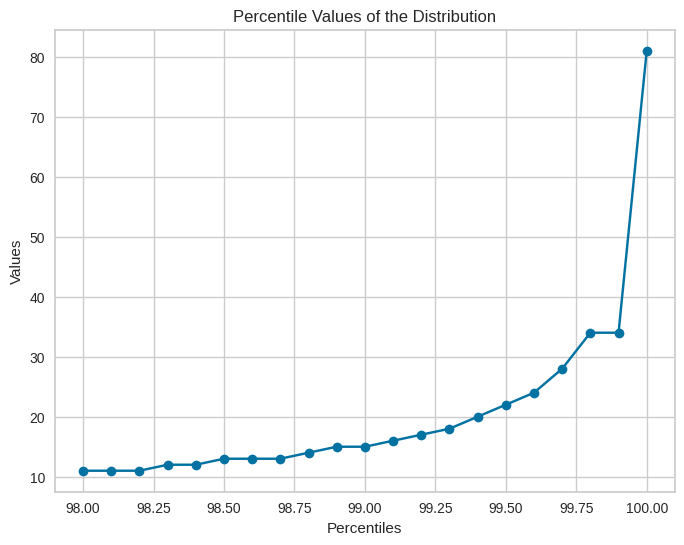

In [ ]:
plot_percentiles(X["max_overdue_count"].dropna(), list(np.arange(98, 100.05, 0.1)))

In [ ]:
X[X["max_overdue_count"] > 35].shape

(148, 16)

__Findings__
- The distribution is skewed due to the presence of outliers.
- There are around 100+ entries beyond the point where the values increases drastically, we can safely drop these entries. However, we will explore further if larger values has any impact on the loan outcome.

##### avg_overdue_amount

In [ ]:
X['avg_overdue_amount'].describe()

count    2.613830e+05
mean     4.715803e+01
std      5.302839e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.617404e+06
Name: avg_overdue_amount, dtype: float64

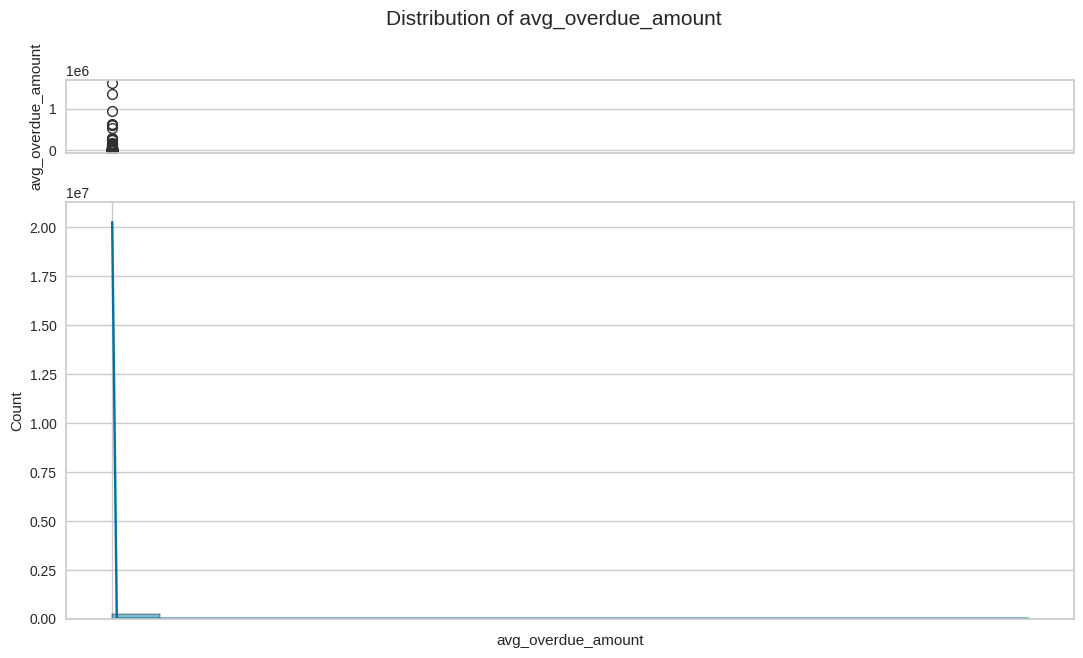

In [ ]:
make_numerical_plots(X, 'avg_overdue_amount')

__Findings:__
- The highest average overdue amount goes upto 16Lakhs.
- The distribution is highly skewed indicating presence of outliers

__Understanding of Outliers:__


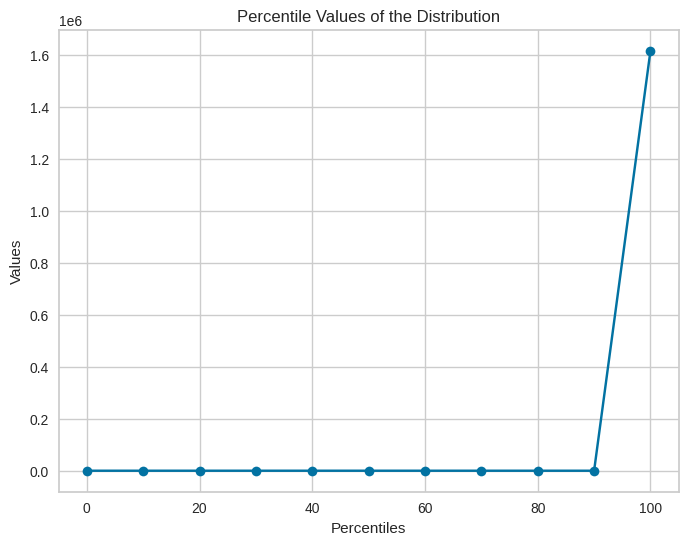

In [ ]:
plot_percentiles(X["avg_overdue_amount"].dropna(), list(np.arange(0, 101, 10)))

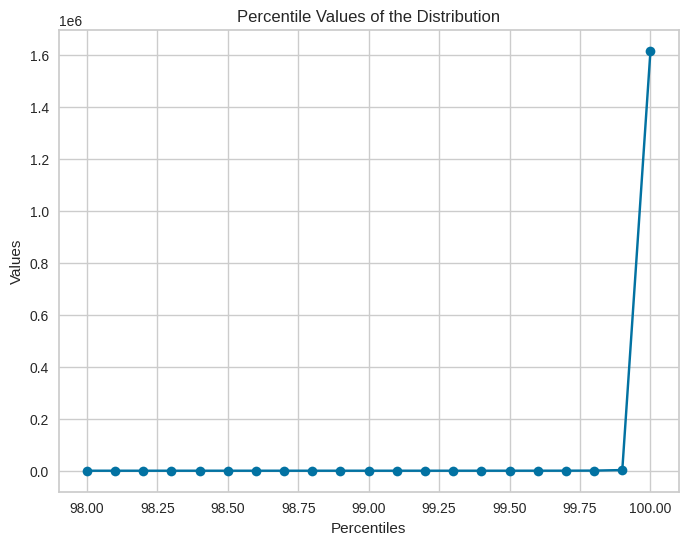

In [ ]:
plot_percentiles(X["avg_overdue_amount"].dropna(), list(np.arange(98, 100.05, 0.1)))

In [ ]:
X.dropna(subset='avg_overdue_amount')[X["avg_overdue_amount"].dropna() > np.percentile(X['avg_overdue_amount'].dropna(), 99.50)].shape[0]

1304

__Findings__
- The distribution is skewed due to the presence of outliers.
- Data suggests the values beyond 99.5 goes up drastically. As there are about ~1K entries beyond this percentile, we can safely drop these entries. However, we will explore further if larger values has any impact on the loan outcome.

#### Credit History

In [ ]:
print(f'Number of missing values total_enquiry_count: {X["total_enquiry_count"].isna().sum()}')
print(f'Number of missing values avg_enquiry_amount: {X["avg_enquiry_amount"].isna().sum()}')
print(f'Number of missing values med_enquiry_amount: {X["med_enquiry_amount"].isna().sum()}')

Number of missing values total_enquiry_count: 0
Number of missing values avg_enquiry_amount: 0
Number of missing values med_enquiry_amount: 0


##### total_enquiry_count

In [ ]:
X['total_enquiry_count'].describe()

count    261383.000000
mean          7.306967
std           6.996937
min           1.000000
25%           2.000000
50%           5.000000
75%          10.000000
max          69.000000
Name: total_enquiry_count, dtype: float64

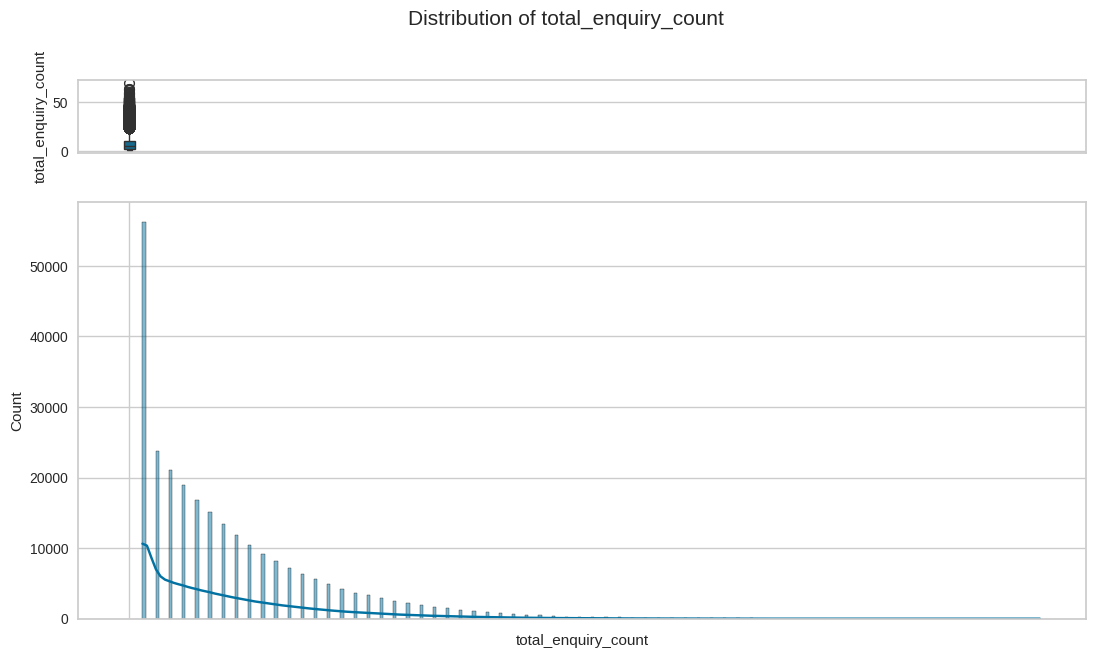

In [ ]:
make_numerical_plots(X, 'total_enquiry_count')

__Findings:__
- The distribution is skewed indicating presence of outliers

__Understanding of Outliers:__


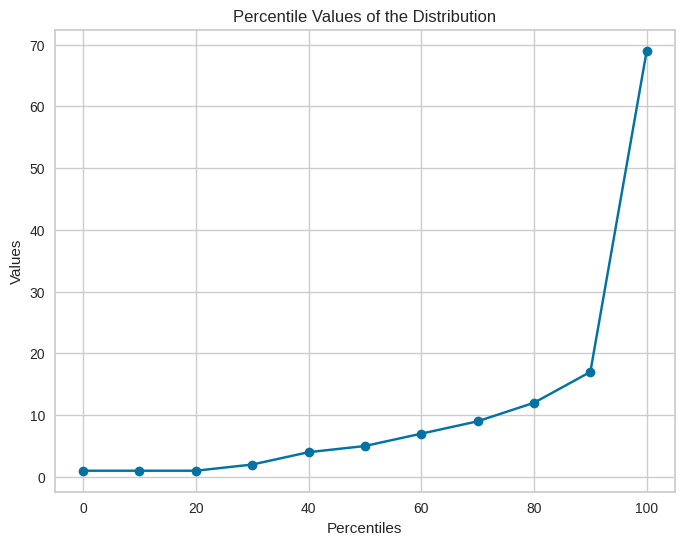

In [ ]:
plot_percentiles(X["total_enquiry_count"].dropna(), list(np.arange(0, 101, 10)))

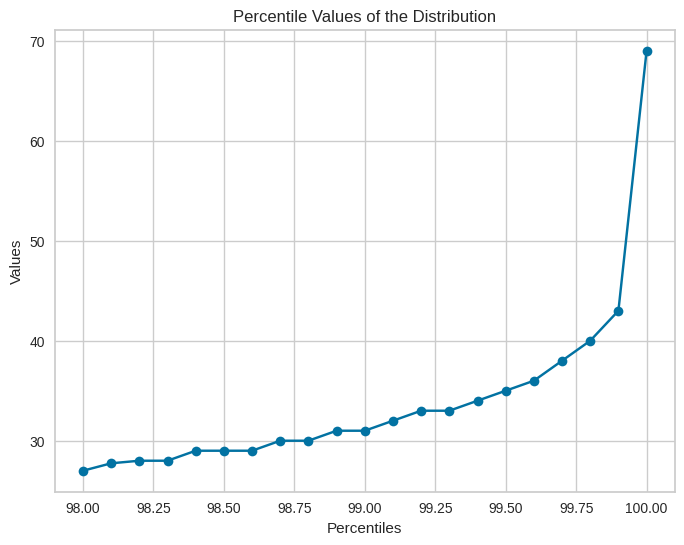

In [ ]:
plot_percentiles(X["total_enquiry_count"].dropna(), list(np.arange(98, 100.05, 0.1)))

In [ ]:
X[X["avg_loan_amount"] > np.percentile(X['avg_loan_amount'].dropna(), 99.75)].shape[0]

654

__Findings__
- The values are not that extreme. We can deal with them.

##### avg_enquiry_amount

In [ ]:
X['avg_enquiry_amount'].describe()

count    261383.000000
mean     116058.619950
std       60605.819470
min        1057.000000
25%       86285.714286
50%      104714.285714
75%      127389.277389
max      499960.000000
Name: avg_enquiry_amount, dtype: float64

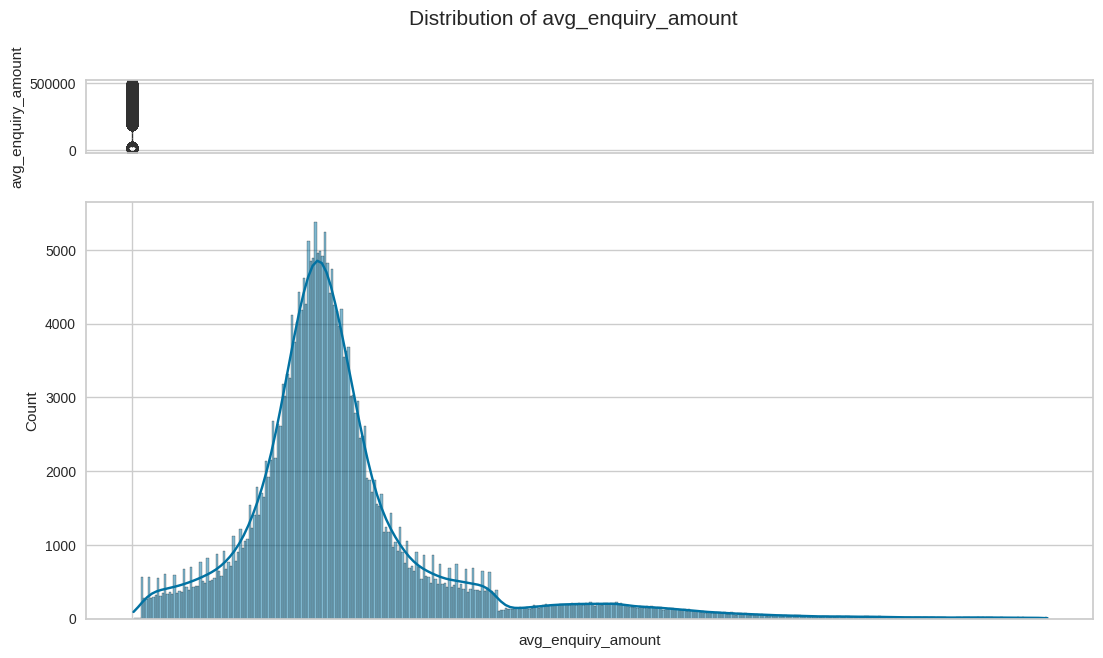

In [ ]:
make_numerical_plots(X, 'avg_enquiry_amount')

__Findings:__
- The distribution looks like a normal distribution

##### med_enquiry_amount

In [ ]:
X['med_enquiry_amount'].describe()

count    261383.000000
mean     116089.412167
std       64846.114297
min        1057.000000
25%       79500.000000
50%      106000.000000
75%      136000.000000
max      499960.000000
Name: med_enquiry_amount, dtype: float64

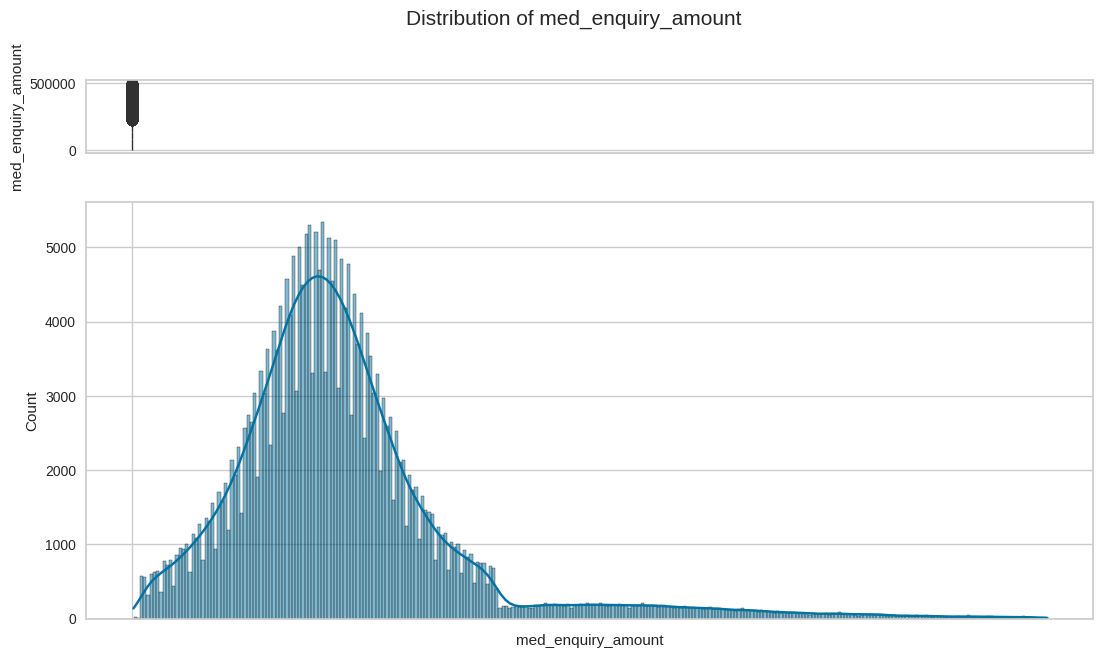

In [ ]:
make_numerical_plots(X, 'med_enquiry_amount')

__Findings:__
- The distribution looks like a normal distribution

## Bivariate Analysis

The dependent variable for our problem statement is "TARGET", and the remaing attribues are the independent variable. We will try to determine if a borrower will default or not given a set of attributes about the borrower.

In [ ]:
from scipy.stats import levene, shapiro, mannwhitneyu, chi2_contingency

### Hypothesis Testing

We will try to find if the predictor variables show a statistically significant difference for borrowers who default and those who pay on time. For each predictor variable we pose the below question:

#### t Test



__Q Is the mean of the distribution for the borrowers who default vs who don't are similar?__

- The null hypothesis, Ho: There is no difference in the mean
- The alternative hypothesis, Ha: There is difference in the mean

Here, we will be conducting a 2-tailed test, with alpha = 0.05

One of the tests that we can use here is t-test. But there are certain assumptions that needs to be fulfilled before proceeding with the test.

Some of the assumptions of t-test:
- the data, when plotted, results in a normal distribution, bell-shaped distribution curve.
- homogeneity of variance.

__Normality check__


We will perform normality check using Shapiro test.

The hypothesis of this test are:
- Null Hypothesis Ho - series is normal
- Alternative Hypothesis Ha - series is not normal

In [ ]:
X.shape, Y.shape

((261383, 16), (261383,))

In [ ]:
def check_normality(series, alpha=0.05):
    _, p_value = shapiro(series)
    if p_value >= alpha:
        return (p_value, 'Accept Ho')
    else:
        return (p_value, 'Reject Ho')

def run_shapiro_test(df, columns):
    """
    Run normality (Shapiro's Test) check on the given columns of the df

    Inputs:
        df: data object
        columns: the columns where normality check would be performed

    Returns:
        A dataframe object containing result of Shapiro's test
    """
    d = {'column': [], 'pval [Class 0]': [], 'result [Class 0]': [], 'pval [Class 1]': [], 'result [Class 1]': []}
    for col in columns:
        p_val0, result0 = check_normality(df[Y == 0][col])
        p_val1, result1 = check_normality(df[Y == 1][col])

        d['column'] += [col]

        d['pval [Class 0]']   += [p_val0]
        d['result [Class 0]'] += [result0]

        d['pval [Class 1]']   += [p_val1]
        d['result [Class 1]'] += [result1]

    return pd.DataFrame(d)

In [ ]:
run_shapiro_test(X, X.columns[1:])

column  pval [Class 0] result [Class 0]  pval [Class 1]  \
0     total_credit_history             0.0        Reject Ho             0.0   
1        avg_overdue_count             0.0        Reject Ho             0.0   
2        pct_overdue_loans             0.0        Reject Ho             0.0   
3        max_overdue_count             0.0        Reject Ho             0.0   
4           cnt_open_loans             0.0        Reject Ho             0.0   
5         cnt_closed_loans             0.0        Reject Ho             0.0   
6       avg_overdue_amount             0.0        Reject Ho             0.0   
7       med_overdue_amount             0.0        Reject Ho             0.0   
8          avg_loan_amount             0.0        Reject Ho             0.0   
9          med_loan_amount             0.0        Reject Ho             0.0   
10   diversity_credit_type             0.0        Reject Ho             0.0   
11     total_enquiry_count             0.0        Reject Ho             0.0   
12      avg_enquiry_amount             0.0        Reject Ho             0.0   
13      med_enquiry_amount             0.0        Reject Ho             0.0   
14  diversity_enquiry_type             0.0        Reject Ho             0.0   

   result [Class 1]  
0         Reject Ho  
1         Reject Ho  
2         Reject Ho  
3         Reject Ho  
4         Reject Ho  
5         Reject Ho  
6         Reject Ho  
7         Reject Ho  
8         Reject Ho  
9         Reject Ho  
10        Reject Ho  
11        Reject Ho  
12        Reject Ho  
13        Reject Ho  
14        Reject Ho

__Findings__
- The distributions do not pass the normality check

__Equality of variance check__

We will perform equivalence check for using using Levene's test.

The hypothesis of this test are:
- Null Hypothesis Ho - Variances are equal
- Alternative Hypothesis Ha - Variances are not equal

In [ ]:
def check_variance(series1, series2, alpha=0.05):
    _, p_value = levene(series1, series2)
    if p_value >= alpha:
        return (p_value, 'Accept Ho')
    else:
        return (p_value, 'Reject Ho')

def run_levene_test(df, columns):
    """
    Run variance equality (Levene's Test) check on the given columns of the df

    Inputs:
        df: data object
        columns: the columns where normality check would be performed

    Returns:
        A dataframe object containing result of Levene's test
    """
    d = {'column': [], 'pval': [], 'result': []}
    for col in columns:
        p_val, result = check_variance(df[Y == 0][col], df[Y == 1][col])

        d['column'] += [col]
        d['pval']   += [p_val]
        d['result'] += [result]

    return pd.DataFrame(d)

In [ ]:
run_levene_test(X, X.columns[1:])

column           pval     result
0     total_credit_history   2.620106e-11  Reject Ho
1        avg_overdue_count   1.193870e-01  Accept Ho
2        pct_overdue_loans   1.310949e-01  Accept Ho
3        max_overdue_count   3.523736e-07  Reject Ho
4           cnt_open_loans  8.775798e-159  Reject Ho
5         cnt_closed_loans   1.566961e-09  Reject Ho
6       avg_overdue_amount   1.708420e-03  Reject Ho
7       med_overdue_amount   9.898715e-02  Accept Ho
8          avg_loan_amount   8.232933e-22  Reject Ho
9          med_loan_amount   7.468351e-14  Reject Ho
10   diversity_credit_type   3.675939e-08  Reject Ho
11     total_enquiry_count   1.831065e-01  Accept Ho
12      avg_enquiry_amount   5.869060e-33  Reject Ho
13      med_enquiry_amount   1.116865e-29  Reject Ho
14  diversity_enquiry_type   4.410529e-01  Accept Ho

__Conclusion__

The distributions fail to satisfy the assumptions of t-test.
Hence, we will use the non-parametric __Mann Whitney test__ to assess whether there is a statistically significant difference in the distributions for borrowers who default vs those who do not default.

__Mann Whitnet Test__

The hypothesis of this test are:
- Null Hypothesis Ho - underlying distribution is same
- Alternative Hypothesis Ha - underlying distribution is not same

We will use alpha = 0.05

In [ ]:
def check_distribution_nonparametric(series1, series2, alpha=0.05):
    _, p_value = mannwhitneyu(series1, series2)
    if p_value >= alpha:
        return (p_value, 'Accept Ho')
    else:
        return (p_value, 'Reject Ho')

def run_mannwhitney_test(df, columns):
    """
    Run Mann Whitney Test on the given columns of the df

    Inputs:
        df: data object
        columns: the columns where normality check would be performed

    Returns:
        A dataframe object containing result of Mann Whitney's test
    """
    d = {'column': [], 'pval': [], 'result': []}
    for col in columns:
        p_val, result = check_distribution_nonparametric(df[Y == 0][col], df[Y == 1][col])

        d['column'] += [col]
        d['pval']   += [p_val]
        d['result'] += [result]

    return pd.DataFrame(d)

In [ ]:
result = run_mannwhitney_test(X, X.columns[1:])
result

column           pval     result
0     total_credit_history   1.217686e-27  Reject Ho
1        avg_overdue_count   6.125212e-08  Reject Ho
2        pct_overdue_loans   3.109335e-06  Reject Ho
3        max_overdue_count   2.712802e-08  Reject Ho
4           cnt_open_loans   5.397245e-51  Reject Ho
5         cnt_closed_loans  4.265552e-147  Reject Ho
6       avg_overdue_amount   4.906357e-57  Reject Ho
7       med_overdue_amount   1.413656e-13  Reject Ho
8          avg_loan_amount   3.132094e-61  Reject Ho
9          med_loan_amount   8.540174e-67  Reject Ho
10   diversity_credit_type   5.384018e-01  Accept Ho
11     total_enquiry_count   9.644163e-01  Accept Ho
12      avg_enquiry_amount   1.259115e-08  Reject Ho
13      med_enquiry_amount   1.225167e-07  Reject Ho
14  diversity_enquiry_type   7.705261e-01  Accept Ho

__Inference__

The variables where the distribution is similar across both classes, it indicates that those feature do not carry much discriminatory power. Including such a feature in the model may not add value and could potentially introduce noise, and lead to overfitting. Hence we will drop all the variables where the null hypothesis are accepted.


In [ ]:
result[result['result'] == 'Accept Ho'].column.to_list()

['diversity_credit_type', 'total_enquiry_count', 'diversity_enquiry_type']

In [ ]:
X.drop(columns=result[result['result'] == 'Accept Ho'].column.to_list(), inplace=True)
X.head()

NAME_CONTRACT_TYPE  total_credit_history  avg_overdue_count  \
0         Cash loans                   1.0                0.0   
1         Cash loans                   1.0                0.0   
2         Cash loans                   1.0                0.0   
3         Cash loans                   3.0                0.0   
4         Cash loans                   0.0                0.0   

   pct_overdue_loans  max_overdue_count  cnt_open_loans  cnt_closed_loans  \
0                0.0                0.0             1.0               0.0   
1                0.0                0.0             0.0               1.0   
2                0.0                0.0             0.0               1.0   
3                0.0                0.0             1.0               2.0   
4                0.0                0.0             0.0               0.0   

   avg_overdue_amount  med_overdue_amount  avg_loan_amount  med_loan_amount  \
0                 0.0                 0.0         450000.0         450000.0   
1                 0.0                 0.0         110155.5         110155.5   
2                 0.0                 0.0         103783.5         103783.5   
3                 0.0                 0.0         224292.0         159525.0   
4                 0.0                 0.0              0.0              0.0   

   avg_enquiry_amount  med_enquiry_amount  
0       135500.000000            135500.0  
1       144333.333333            150000.0  
2       120500.000000            153500.0  
3       148000.000000            148000.0  
4       110318.181818            109000.0

#### Chi Squared Test

__Q Is the proportion of loan default significantly different across different contract type?__

- The null hypothesis, Ho: There is no difference in the proportion of loan defaults for different contract types
- The alternative hypothesis, Ha: There is difference in the proportion of loan defaults for different contract types

Here, we will be conducting a test, with alpha = 0.05

One of the tests that we can use here is chi-square test.

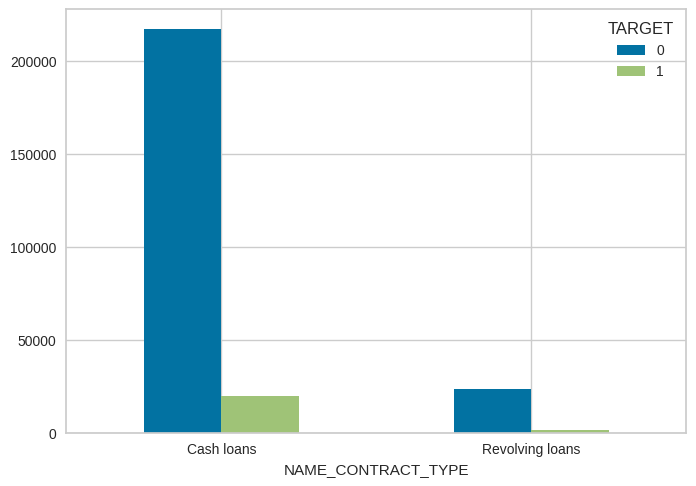

In [ ]:
contigency_loan_outcome = pd.crosstab(X['NAME_CONTRACT_TYPE'], Y)
contigency_loan_outcome.plot(kind="bar", stacked=False, rot=0)
plt.show()

In [ ]:
chi2, pval, dof, exp_freq = chi2_contingency(contigency_loan_outcome, correction=False)

if pval >= 0.05:
    print('We fail to reject the Null Hypothesis Ho')
else:
    print('We reject the Null Hypothesis Ho')

We reject the Null Hypothesis Ho


__Findings__  
- We reject the Null Hypothesis Ho

### Pairplot, Correlation

<Figure size 1300x500 with 0 Axes>

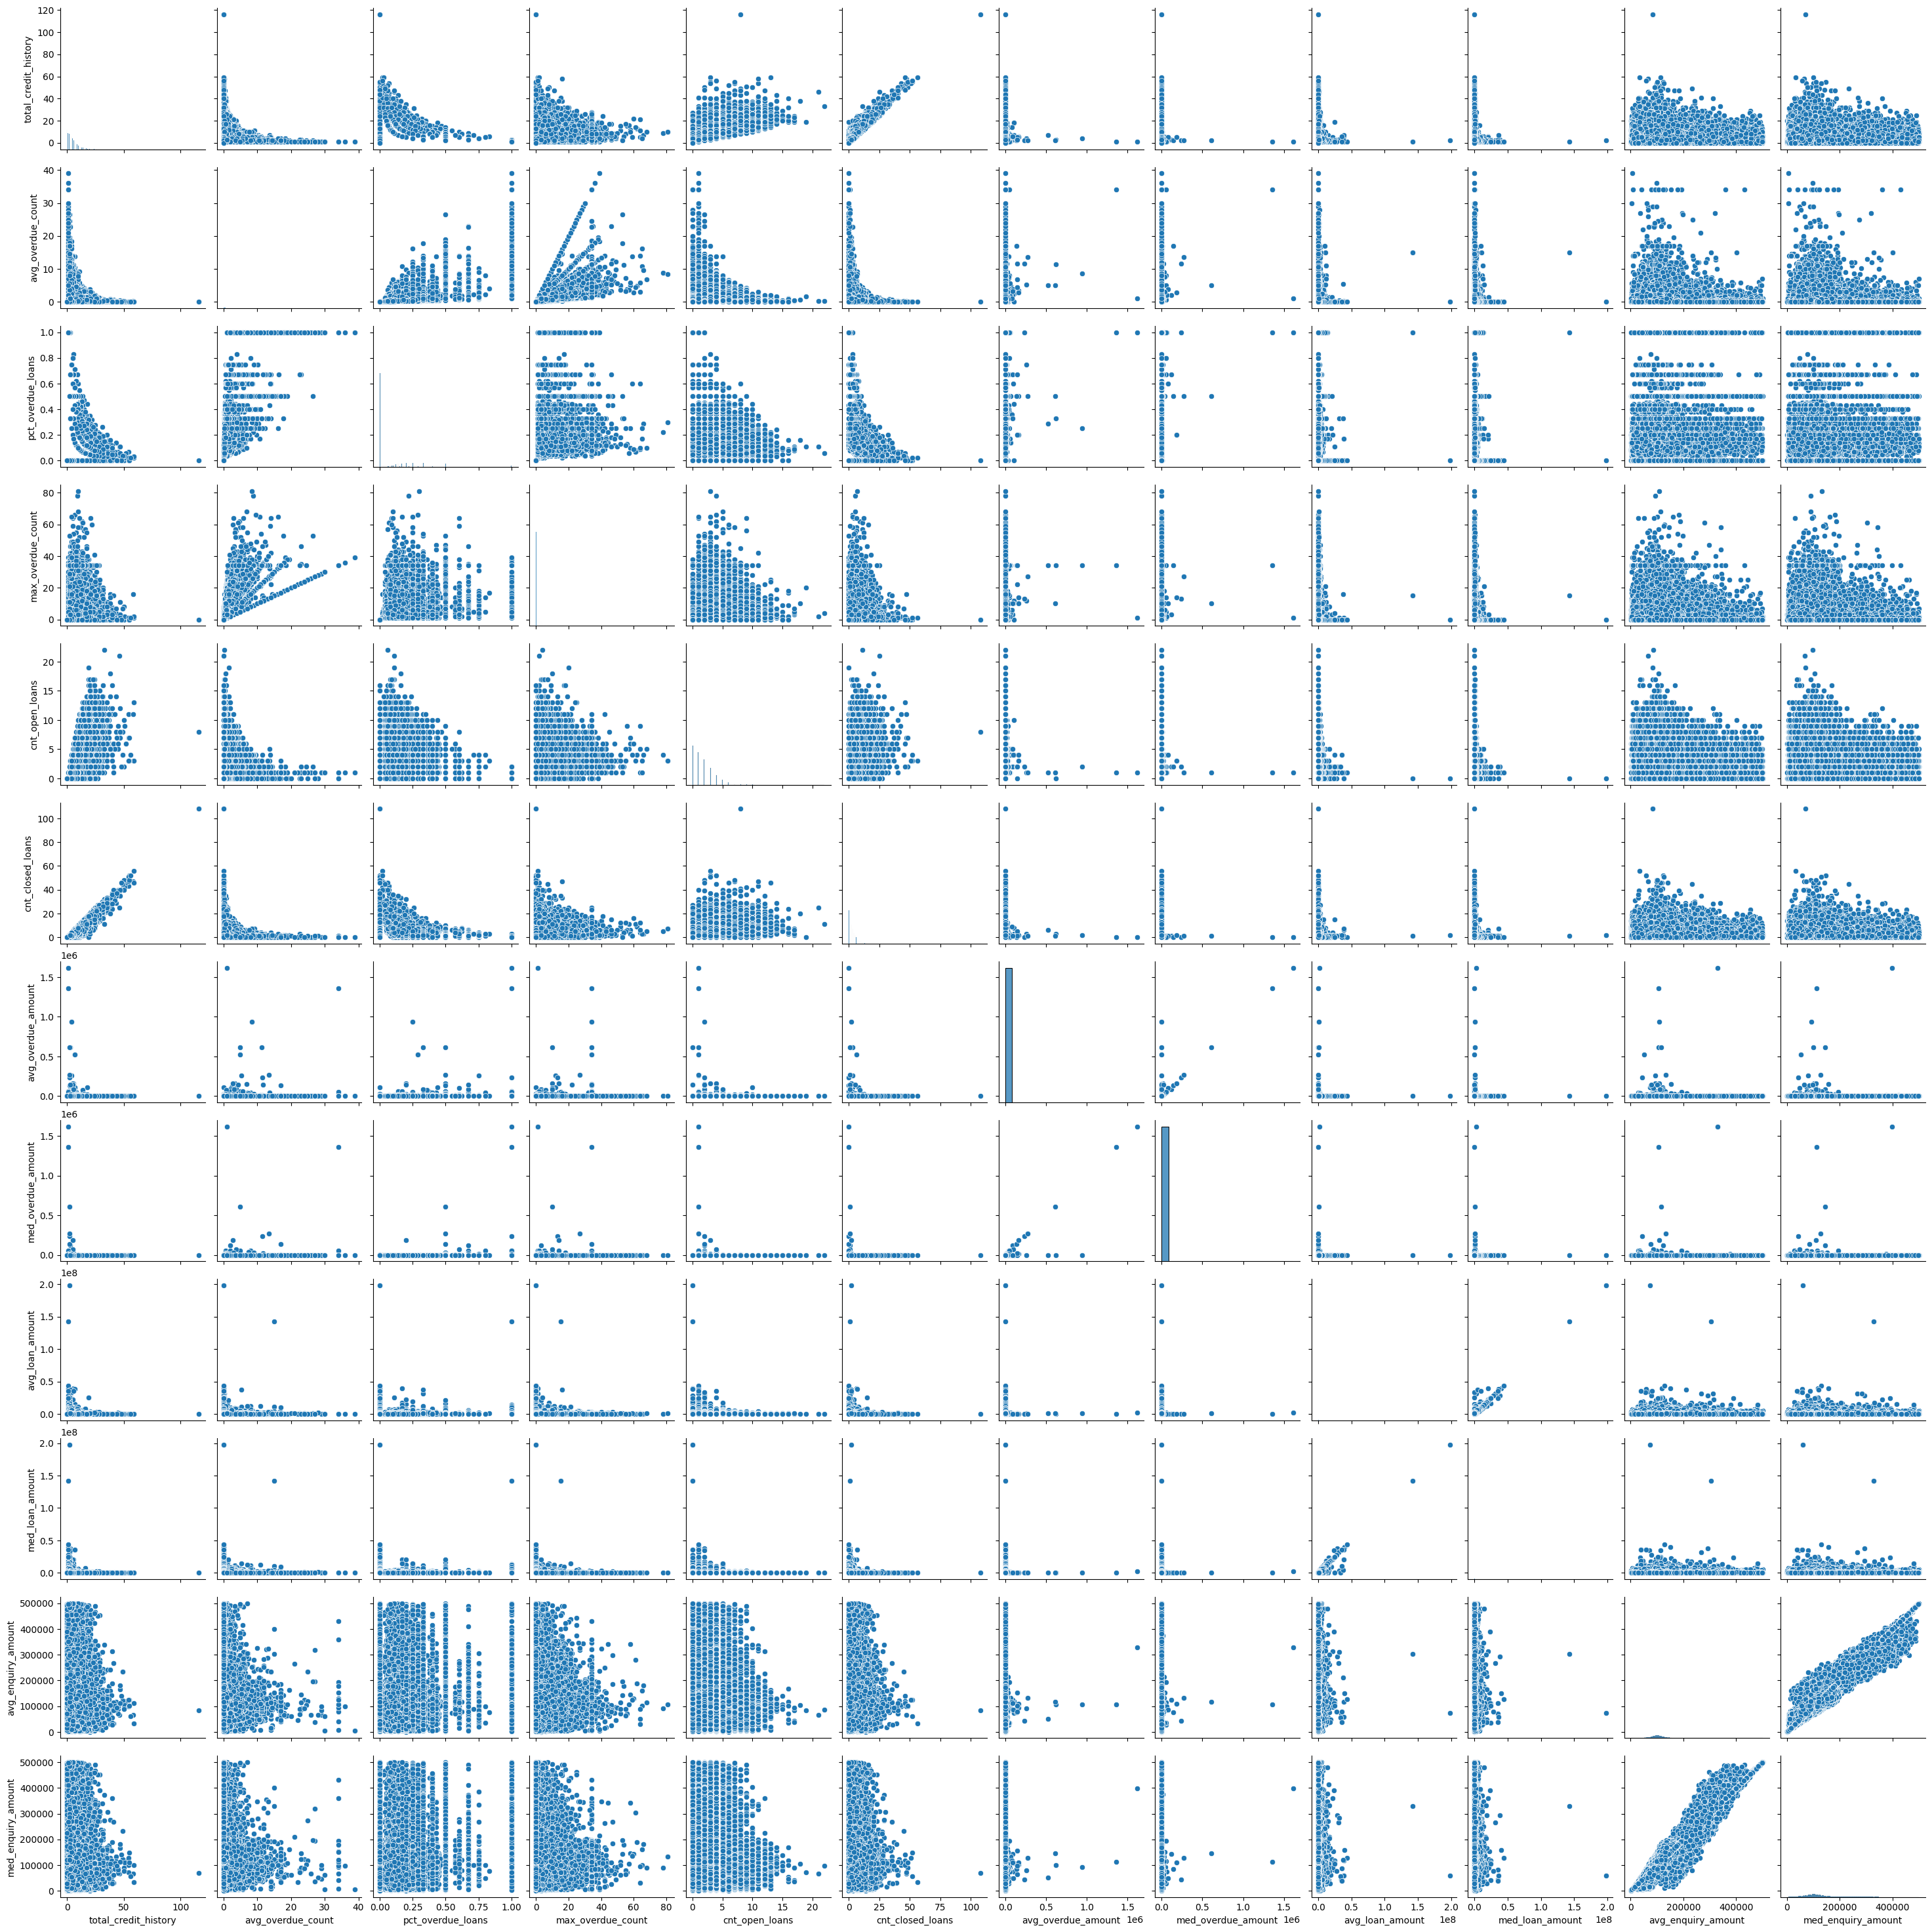

In [ ]:
plt.figure(figsize=(13,5))
sns.pairplot(X)
plt.show()

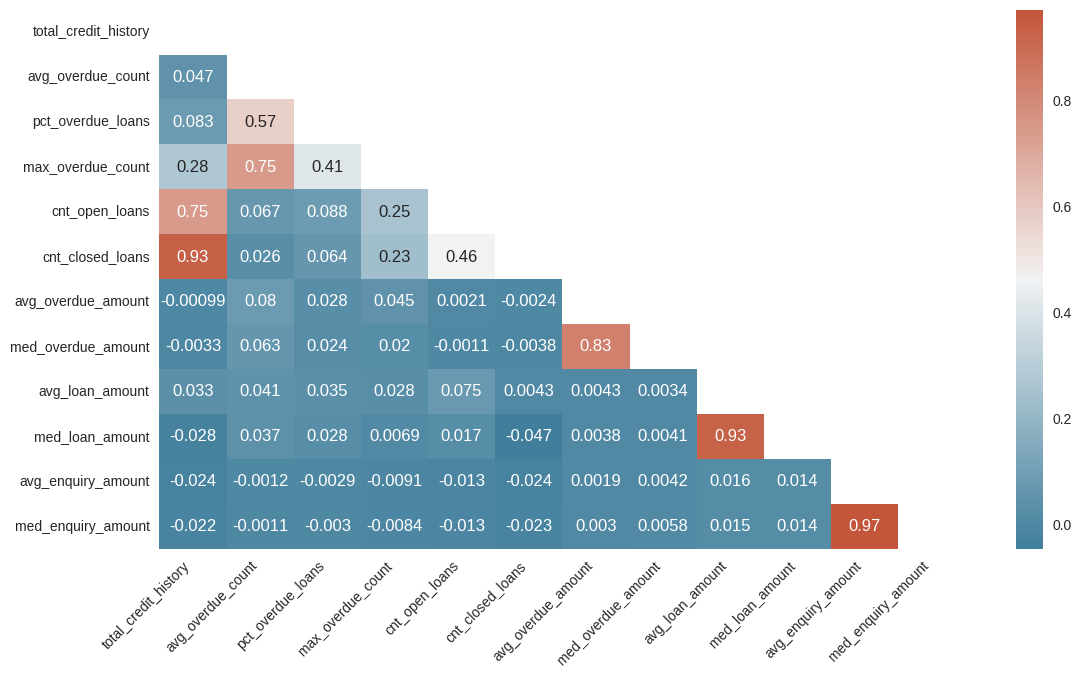

In [ ]:
# Correlation between different variables
corr = X.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(13, 7))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

__Findings:__
- Some of the variable pairs show any strong correlation among themselves. We can drop either one from the pairs.
- The following pairs have a high correlation: `[avg_overdue_amount, med_overdue_amount]`, `[avg_loan_amount, med_loan_amount]`, `[avg_enquiry_amount, med_enquiry_amount]`

In [ ]:
X = X.drop(columns=['med_overdue_amount', 'med_loan_amount', 'med_enquiry_amount'])
X.head()

NAME_CONTRACT_TYPE  total_credit_history  avg_overdue_count  \
0         Cash loans                   1.0                0.0   
1         Cash loans                   1.0                0.0   
2         Cash loans                   1.0                0.0   
3         Cash loans                   3.0                0.0   
4         Cash loans                   0.0                0.0   

   pct_overdue_loans  max_overdue_count  cnt_open_loans  cnt_closed_loans  \
0                0.0                0.0             1.0               0.0   
1                0.0                0.0             0.0               1.0   
2                0.0                0.0             0.0               1.0   
3                0.0                0.0             1.0               2.0   
4                0.0                0.0             0.0               0.0   

   avg_overdue_amount  avg_loan_amount  avg_enquiry_amount  
0                 0.0         450000.0       135500.000000  
1                 0.0         110155.5       144333.333333  
2                 0.0         103783.5       120500.000000  
3                 0.0         224292.0       148000.000000  
4                 0.0              0.0       110318.181818

__Summary__
- We analysed each feature individually to understand their underlying patterns
- The data analysis gave us a insight on how to impute the values
- Effect of predictor features on the target, and the correlation among themselves were checked. Actions were taken accordingly.
- Outliers were discovered in the numerical distributions.

__NOTE:__ Extreme values in a use case like this might represent significant financial transactions or unique scenarios. Retaining this information could enhance the model's ability to identify patterns associated with higher-risk loans. Such values may be reflective of certain business realities, and removing them could lead to a loss of valuable insights into the underlying dynamics of the loan portfolio.

To handle such extreme values we can use machine learning algorithms that are inherently robust to outliers. For instance, Decision tree-based models.
Or we can also apply appropriate transformations like log transformation that can mitigate skewness without removing extreme values.


# Data Preparation + Modelling

In [6]:
# !pip install pycaret
from pycaret.classification import *

We will apply the data processing steps learned from the training data in the EDA steps above to the test data.

Following steps will be applied:
- remove the redundant feautures
- fill missing values

In [7]:
def clean_dataframe(df, required_cols):
    # keep only useful columns
    df = df[required_cols]
    # impute null values with 0
    df = df.fillna(0)
    return df

required_cols = ['NAME_CONTRACT_TYPE', 'total_credit_history', 'avg_overdue_count',
                 'pct_overdue_loans', 'max_overdue_count', 'cnt_open_loans',
                 'cnt_closed_loans', 'avg_overdue_amount', 'avg_loan_amount',
                 'avg_enquiry_amount']

In [9]:
num_cols = ['total_credit_history', 'avg_overdue_count', 'pct_overdue_loans',
            'max_overdue_count', 'cnt_open_loans', 'cnt_closed_loans',
            'avg_overdue_amount', 'avg_loan_amount', 'avg_enquiry_amount']
cat_cols = ['NAME_CONTRACT_TYPE']

data = X.copy()
data['target'] = Y

## Modelling - Iteration 1
We will train ML algorithms that are inherently robust to outliers in addition to following charateristics:
- we will not do any data balancing
- we will encode the categorical variable
- we will not scale the numerical variables


In [ ]:
exp1 = ClassificationExperiment()
exp1.setup(data,
          target = 'target',
          session_id = 123,
          train_size = 0.8,
          fold = 5)

In [ ]:
exp1.remove_metric('Accuracy')
exp1.remove_metric('Recall')
exp1.remove_metric('Precision')
exp1.remove_metric('F1')
exp1.remove_metric('Kappa')
exp1.remove_metric('MCC')

In [ ]:
best1 = exp1.compare_models(include = ['dt', 'rf', 'gbc', 'xgboost', 'lightgbm'], sort = 'AUC')

Processing:   0%|          | 0/25 [00:00<?, ?it/s]

## Modelling - Iteration 2
We will train ML algorithms with the following charateristics:
- we will not do any data balancing
- we will encode the categorical variable
- we will apply robust scaling to the numerical variables


In [ ]:
exp2 = ClassificationExperiment()
exp2.setup(data,
          target = 'target',
          session_id = 123,
          train_size = 0.8,
          fold = 5,
          normalize = True,
          normalize_method = 'robust')

In [ ]:
exp2.remove_metric('Accuracy')
exp2.remove_metric('Recall')
exp2.remove_metric('Precision')
exp2.remove_metric('F1')
exp2.remove_metric('Kappa')
exp2.remove_metric('MCC')

In [ ]:
best2 = exp2.compare_models(include = ['lr', 'knn', 'nb'], sort = 'AUC')

Processing:   0%|          | 0/17 [00:00<?, ?it/s]

## Modelling - Iteration 3
We will train ML algorithms that have the following charateristics:
- we will use SMOTE for data balancing
- we will encode the categorical variable
- we will apply robust scaling the numerical variables


In [ ]:
exp3 = ClassificationExperiment()
exp3.setup(data,
          target = 'target',
          session_id = 123,
          train_size = 0.8,
          fold = 5,
          normalize = True,
          normalize_method = 'robust',
          fix_imbalance = True)

In [ ]:
exp3.remove_metric('Accuracy')
exp3.remove_metric('Recall')
exp3.remove_metric('Precision')
exp3.remove_metric('F1')
exp3.remove_metric('Kappa')
exp3.remove_metric('MCC')

In [ ]:
best3 = exp3.compare_models(include = ['lr', 'knn', 'nb', 'rf', 'gbc', 'xgboost', 'lightgbm'], sort = 'AUC')

Processing:   0%|          | 0/33 [00:00<?, ?it/s]

## Modelling - Iteration 4
We will train ML algorithms that have the following charateristics:
- we will use SMOTE for class balancing
- we will encode the categorical variable
- we will remove outliers manually


In [ ]:
def clean_outliers(data):
    """
    Remove outliers based on the threshold observed during EDA

    Input:
        data: dataframe
    Returns:
        A tuple with containing the threshold values for the columns
    and the transformed data after removing outliers

    """
    cap_val_dict = {}
    for col in data.columns[1:-1]:
        cap_val = np.percentile(data[col], 99.75)
        cap_val_dict[col] = cap_val

    for col in data.columns[1:-1]:
        data = data[data[col] < cap_val_dict[col]]

    return (cap_val_dict, data)

In [ ]:
pctile_dict, clean_df = clean_outliers(data)

In [ ]:
exp4 = ClassificationExperiment()
exp4.setup(clean_df,
          target = 'target',
          session_id = 123,
          train_size = 0.8,
          fold = 5,
          fix_imbalance = True)
exp4.set_config('seed', 42)

In [ ]:
exp4.remove_metric('Accuracy')
exp4.remove_metric('Recall')
exp4.remove_metric('Precision')
exp4.remove_metric('F1')
exp4.remove_metric('Kappa')
exp4.remove_metric('MCC')

In [ ]:
best4 = exp4.compare_models(include = ['lr', 'knn', 'nb', 'rf', 'gbc', 'xgboost', 'lightgbm'], sort = 'AUC')

Processing:   0%|          | 0/33 [00:00<?, ?it/s]

## Modelling - Iteration 5
We will train ML algorithms that have the following charateristics:
- we will not use class balancing
- we will encode the categorical variable
- we will remove outliers manually


In [ ]:
pctile_dict, clean_df = clean_outliers(data)

In [ ]:
exp5 = ClassificationExperiment()
exp5.setup(clean_df,
          target = 'target',
          session_id = 123,
          train_size = 0.8,
          fold = 5,
          fix_imbalance = False)
exp5.set_config('seed', 42)

In [ ]:
exp5.remove_metric('Accuracy')
exp5.remove_metric('Recall')
exp5.remove_metric('Precision')
exp5.remove_metric('F1')
exp5.remove_metric('Kappa')
exp5.remove_metric('MCC')

In [ ]:
exp5 = exp5.compare_models(include = ['lr', 'knn', 'nb', 'rf', 'gbc', 'xgboost', 'lightgbm'], sort = 'AUC')

Processing:   0%|          | 0/33 [00:00<?, ?it/s]

## Final Model

Based on above experimentation, the Gradient Boosting model from Iteration 1 seems to be the most promising one. We will fine tune it to obtain the final model.

In [10]:
expf = ClassificationExperiment()
expf.setup(data,
          target = 'target',
          session_id = 123,
          train_size = 0.8,
          fold = 5,
          feature_selection = True,
          n_features_to_select = 5)

expf.set_config('seed', 42)

In [11]:
expf.remove_metric('Accuracy')
expf.remove_metric('Recall')
expf.remove_metric('Precision')
expf.remove_metric('F1')
expf.remove_metric('Kappa')
expf.remove_metric('MCC')

In [12]:
model = expf.create_model('gbc', return_train_score = True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
tuned_model = expf.tune_model(model, optimize = 'AUC', return_train_score = True)

Initiated  . . . . . . . . . . . . . . . . . .                      10:14:22
Status     . . . . . . . . . . . . . . . . . .       Compiling Final Results
Estimator  . . . . . . . . . . . . . . . . . .  Gradient Boosting Classifier

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


__AUC Plot__

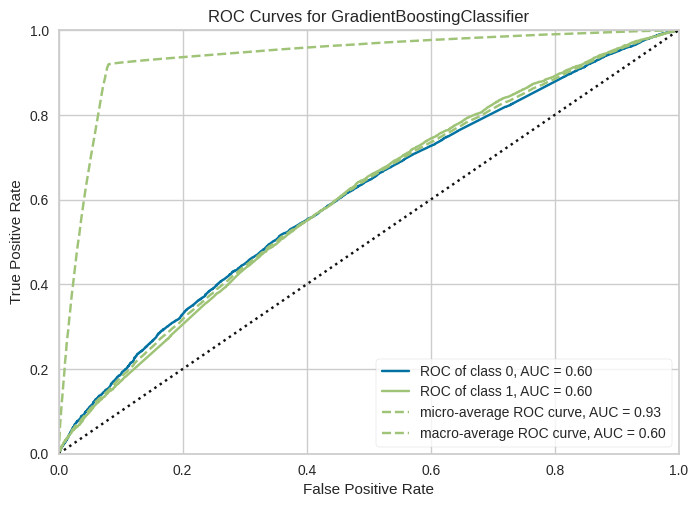

In [14]:
# plot AUC
expf.plot_model(tuned_model, plot = 'auc')

__Feature Importance__

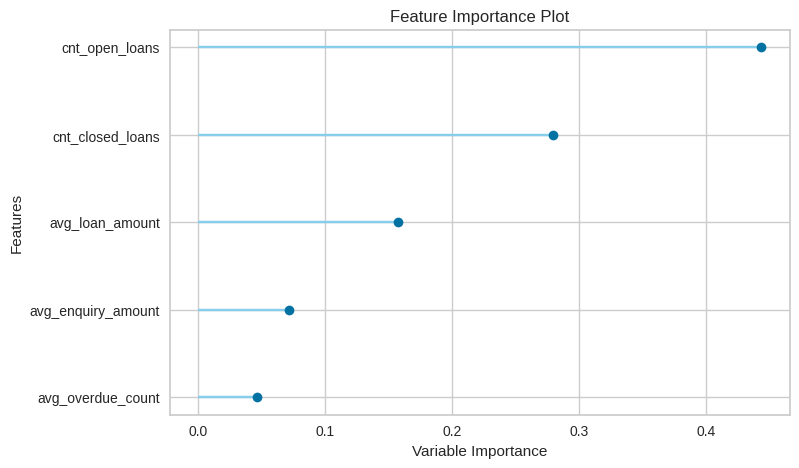

In [15]:
# plot feature importance
expf.plot_model(tuned_model, plot = 'feature')

#### Calibrating the model

In many machine learning task it's important for the predicted probabilities to reflect the actual probability of the events occurring. Calibration ensures that the model's predicted probabilities are reliable and can be interpreted as meaningful estimates of the true probabilities.

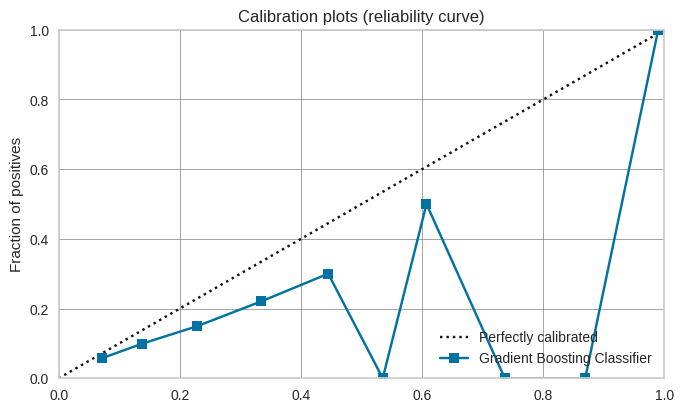

In [16]:
expf.plot_model(tuned_model, plot = 'calibration')


In [20]:
# calibrate model
calibrated_dt = expf.calibrate_model(tuned_model, method = 'isotonic', return_train_score = True)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

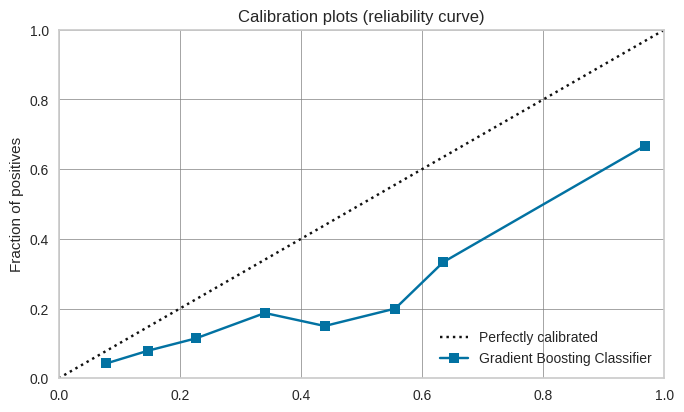

In [21]:
expf.plot_model(calibrated_dt, plot = 'calibration')

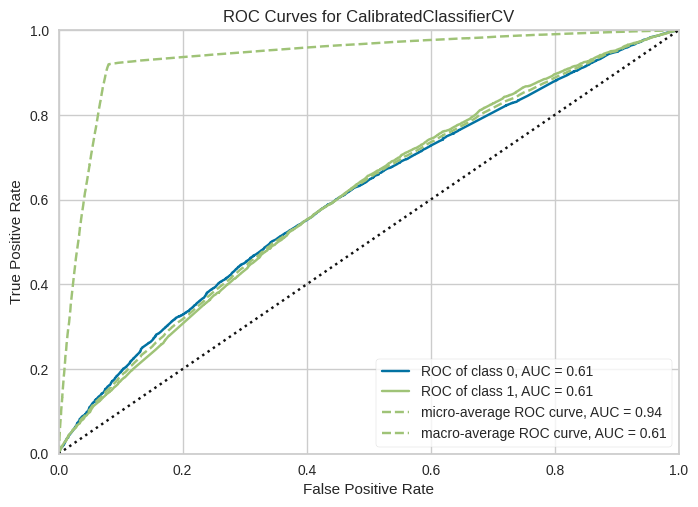

In [56]:
expf.plot_model(calibrated_dt, plot = 'auc')

In [22]:
final_best = expf.finalize_model(calibrated_dt)
expf.save_model(final_best, 'monsoon_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['total_credit_history',
                                              'avg_overdue_count',
                                              'pct_overdue_loans',
                                              'max_overdue_count',
                                              'cnt_open_loans',
                                              'cnt_closed_loans',
                                              'avg_overdue_amount',
                                              'avg_loan_amount',
                                              'avg_enquiry_amount'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_va...
                                   

## Prediction on Test Data

Applying all the transformations applied on the train data to test data:

In [23]:
loan_df_test = pd.read_csv('/content/senior_ds_test/data/test/test_flag.csv')
loan_df_test.head(2)

uid NAME_CONTRACT_TYPE
0  CMO22835242         Cash loans
1  MRJ34316727         Cash loans

In [25]:
accounts_df_test = load_json_to_df('/content/senior_ds_test/data/test/accounts_data_test.json')
accounts_df_test.head(2)

credit_type  loan_amount  amount_overdue   open_date closed_date  \
0  Consumer credit     31630.50             0.0  2014-03-30  2014-11-29   
1  Consumer credit     14613.39             0.0  2014-06-01  2014-11-03   

        payment_hist_string          uid  
0  000000000000000000000000  AAA14437029  
1           000000000000000  AAA14437029

In [26]:
enquiry_df_test = load_json_to_df('/content/senior_ds_test/data/test/enquiry_data_test.json')
enquiry_df_test.head(2)

enquiry_type  enquiry_amt enquiry_date          uid
0          Car loan       143000   2020-12-13  AAA02107680
1  Real estate loan       174000   2020-12-01  AAA14437029

In [27]:
duplicate = loan_df_test[loan_df_test.duplicated(keep = 'last')]
duplicate.shape

(0, 2)

In [28]:
duplicate = accounts_df_test[accounts_df_test.duplicated(keep = 'last')]
duplicate.shape

(1104, 7)

In [29]:
duplicate = enquiry_df_test[enquiry_df_test.duplicated(keep = 'last')]
duplicate.shape

(0, 4)

In [30]:
before = accounts_df_test.shape[0]
accounts_df_test = accounts_df_test[~accounts_df_test.duplicated(keep = 'last')].reset_index(drop=True)
print(f'{before - accounts_df_test.shape[0]} entries were dropped from accounts_df test')

1104 entries were dropped from accounts_df test


In [32]:
# number of overdues in a loan
accounts_df_test['overdue_count'] = accounts_df_test['payment_hist_string'].apply(get_overdues_count)

agg_accounts_df_test = accounts_df_test.groupby('uid').agg(

    # number of credit history
    total_credit_history = ('uid', 'size'),

    # average number of overdues in a loan
    avg_overdue_count    = ('overdue_count', 'mean'),
    # percentage of loans with overdue
    pct_overdue_loans    = ('overdue_count', get_overdue_pct),
    # maximum number of defaults in a loan
    max_overdue_count    = ('overdue_count', 'max'),

    # number of open loans
    cnt_open_loans       = ('closed_date', get_open_loan_count),
    # number of closed loans
    cnt_closed_loans     = ('closed_date', get_closed_loan_count),

    # average/median of the overdue amount
    avg_overdue_amount   = ('amount_overdue', 'mean'),
    med_overdue_amount   = ('amount_overdue', np.median),

    # average/median of the loan amount taken
    avg_loan_amount      = ('loan_amount', 'mean'),
    med_loan_amount      = ('loan_amount', np.median),

    # credit type diversity
    diversity_credit_type = ('credit_type', entropy)

).reset_index()

In [33]:
agg_enquiry_df_test = enquiry_df_test.groupby('uid').agg(

    # number of enquiries made
    total_enquiry_count = ('uid', 'size'),

    # average/median of the enquiry amount
    avg_enquiry_amount      = ('enquiry_amt', 'mean'),
    med_enquiry_amount      = ('enquiry_amt', np.median),

    # enquiry type diversity
    diversity_enquiry_type = ('enquiry_type', entropy)

).reset_index()

In [42]:
test_df = loan_df_test.merge(agg_accounts_df_test, on='uid', how='left')\
                      .merge(agg_enquiry_df_test,  on='uid', how='left')

test_df.head(2)

uid NAME_CONTRACT_TYPE  total_credit_history  avg_overdue_count  \
0  CMO22835242         Cash loans                  13.0           0.076923   
1  MRJ34316727         Cash loans                   6.0           0.000000   

   pct_overdue_loans  max_overdue_count  cnt_open_loans  cnt_closed_loans  \
0               0.08                1.0             2.0              11.0   
1               0.00                0.0             4.0               2.0   

   avg_overdue_amount  med_overdue_amount  avg_loan_amount  med_loan_amount  \
0                 0.0                 0.0    795236.773846          90000.0   
1                 0.0                 0.0    294915.000000         112500.0   

   diversity_credit_type  total_enquiry_count  avg_enquiry_amount  \
0               1.090599                    8            129500.0   
1               0.450561                    1            184000.0   

   med_enquiry_amount  diversity_enquiry_type  
0            140000.0                1.732868  
1            184000.0                0.000000

In [46]:
def clean_dataframe(df, required_cols):
    # keep only useful columns
    df = df[required_cols]
    # impute null values with 0
    df = df.fillna(0)
    return df

required_cols = ['NAME_CONTRACT_TYPE', 'total_credit_history', 'avg_overdue_count',
                 'pct_overdue_loans', 'max_overdue_count', 'cnt_open_loans',
                 'cnt_closed_loans', 'avg_overdue_amount', 'avg_loan_amount',
                 'avg_enquiry_amount']
test_df = clean_dataframe(test_df, required_cols)

In [45]:
ids = test_df.uid

In [53]:
preds = final_best.predict_proba(test_df)[:, 1]

In [54]:
submission = pd.DataFrame({'uid': ids, 'pred': preds})
submission.head(2)

uid      pred
0  CMO22835242  0.040429
1  MRJ34316727  0.106189

In [55]:
submission.to_csv('final_submission_Tulrose_Deori.csv', index=False)

## Summary

Our final model is Gradient Boosted Classifier, and its score validation set are:
- micro averaged AUC = 0.94
- macro averaged AUC = 0.61

The most important features are (in order):
- cnt_open_loans
- cnt_closed_loans
- avg_loan_amount
- avg_enquiry_amount
- avg_overdue_count


About Feature Importance:
- The higher the magnitude of the feature importance value, the more power it has to predict the loan outcome
- For better explainability of the dependent variable, we want the magnitude of coefficient values of the independent variables to be high. That means,  the larger the magnitude of coefficient is, higher is the impact of that feature on the dependent feature.

# Scope of Improvements

We can come up with more number of attributes during the aggregation step. For instance, we could create features based on the credit type information from accounts data. The date informations can be used to create features related to Recency.